## ELETTRA-31: IDs interaction residual correction (ORM)

In [1]:
# In this example interaction between several EPU devices is further explored

# Local correction for single ID is first computed using reduced ORM matrix and local knobs
# Next, several identical devices are inserted and feed-forward corrections are applied

# Residual optics errors are explored (after global tune correction)
# An attempt to correct residual errors by allowing all local knobs to change is performed (with and without applied feed-forward)
# Keeping symmetry relations for local knobs from the same section

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.corrector import Corrector
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.orbit import ORM
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

from model.command.wrapper import Wrapper
from model.command.wrapper import forward
from model.command.wrapper import inverse
from model.command.wrapper import normalize

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Single ID compensation

In [5]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [6]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Insert correctors

for name, *_ in ring.layout():
    if name.startswith('CH'):
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector])

# Merge drifts

ring.merge()

# Change lattice start start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice

ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Marker': 12}

In [7]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [8]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, orbit, [], limit=1)

In [9]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

In [10]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

In [11]:
# Compute coupling

c = coupling(ring, [])

In [12]:
# Quadrupole names for global tune correction

QF = [f'QF_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QD = [f'QD_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]

In [13]:
# Global tune responce matrix

def global_observable(knobs):
    kf, kd = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd])
    return tune(ring, [kn], ('kn', None, QF + QD, None), matched=True, limit=1)

knobs = torch.tensor([0.0, 0.0], dtype=dtype)
global_target = global_observable(knobs)
global_matrix = torch.func.jacfwd(global_observable)(knobs)

print(global_target)
print(global_matrix)

tensor([0.2994, 0.1608], dtype=torch.float64)
tensor([[ 5.8543,  2.0964],
        [-2.9918, -1.2602]], dtype=torch.float64)


In [14]:
# Local knobs

sid = 'S01'

# Normal quadrupole correctors

nkn = [f'OCT_{sid}_02', f'QF_{sid}_02', f'QD_{sid}_02', f'QD_{sid}_03', f'QF_{sid}_03', f'OCT_{sid}_03']

# Skew quadrupole correctors

nks = [f'SD_{sid}_05', f'SH_{sid}_02', f'SH_{sid}_03', f'SD_{sid}_06']

In [15]:
# Define knobs to magnets mixing matrices

Sn = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]], dtype=dtype)

print(Sn)
print()

Ss = torch.tensor([[+1.0, 0.0], [0.0, +1.0], [0.0, -1.0], [-1.0, 0.0]], dtype=dtype)

print(Ss)
print()

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=torch.float64)

tensor([[ 1.,  0.],
        [ 0.,  1.],
        [ 0., -1.],
        [-1.,  0.]], dtype=torch.float64)



In [16]:
# Define observables for 'mixed' knobs

def knobs_split(knobs):
    kn, ks = torch.split(knobs, [3, 2])
    kn = Sn @ kn
    ks = Ss @ ks
    return kn, ks


def knobs_build(knobs):
    kn, ks = knobs_split(knobs)
    return (nkn, kn), (nks, ks)


def observable_orm(nn, kn, ns, ks):
    orm = ORM(ring, orbit,  [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), limit=1)
    return orm


def observable(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    orm = observable_orm(nn, kn, ns, ks)
    return orm.flatten()


knobs = torch.tensor((3 + 2)*[0.0], dtype=dtype)
print((target := observable(knobs)).shape)
print((matrix := torch.func.jacfwd(observable)(knobs)).shape)

torch.Size([16128])
torch.Size([16128, 5])


In [17]:
# Define ID model
# Note, only the flattened triangular part of the A and B matrices is passed

A = torch.tensor([[-0.03484222052711237, 1.0272120741819959E-7, -4.698931299341201E-9, 0.0015923185492594811],
                  [1.0272120579834892E-7, -0.046082787920135176, 0.0017792061173117564, 3.3551298301095784E-8],
                  [-4.6989312853101E-9, 0.0017792061173117072, 0.056853750760983084, -1.5929605363332683E-7],
                  [0.0015923185492594336, 3.3551298348653296E-8, -1.5929605261642905E-7, 0.08311631737263032]], dtype=dtype)

B = torch.tensor([[0.03649353186115209, 0.0015448347221877217, 0.00002719892025520868, -0.0033681183134964482],
                  [0.0015448347221877217, 0.13683886657005795, -0.0033198692682377406, 0.00006140578258682469],
                  [0.00002719892025520868, -0.0033198692682377406, -0.05260095308967722, 0.005019907688182885],
                  [-0.0033681183134964482, 0.00006140578258682469, 0.005019907688182885, -0.2531573249456863]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [18]:
# Insert ID into the existing lattice
# This will replace the target marker

error = ring.clone()
error.flatten()
error.insert(ID, 'MLL_S01', position=0.0)
error.splice()

# Describe

error.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Matrix': 1,
 'Marker': 11}

In [19]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(error, [], matched=True, limit=1)

In [20]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(error, orbit, [], limit=1)

In [21]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(error, [], matched=True, advance=True, full=False).T

In [22]:
# Compute phase advances

mux_id, muy_id = advance(error, [], alignment=False, matched=True).T

In [23]:
# Compute coupling

c_id = coupling(error, [])

In [24]:
# Tune shifts

print((nux - nux_id))
print((nuy - nuy_id))

tensor(0.0260, dtype=torch.float64)
tensor(-0.0114, dtype=torch.float64)


In [25]:
# Coupling (minimal tune distance)

print(c)
print(c_id)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)


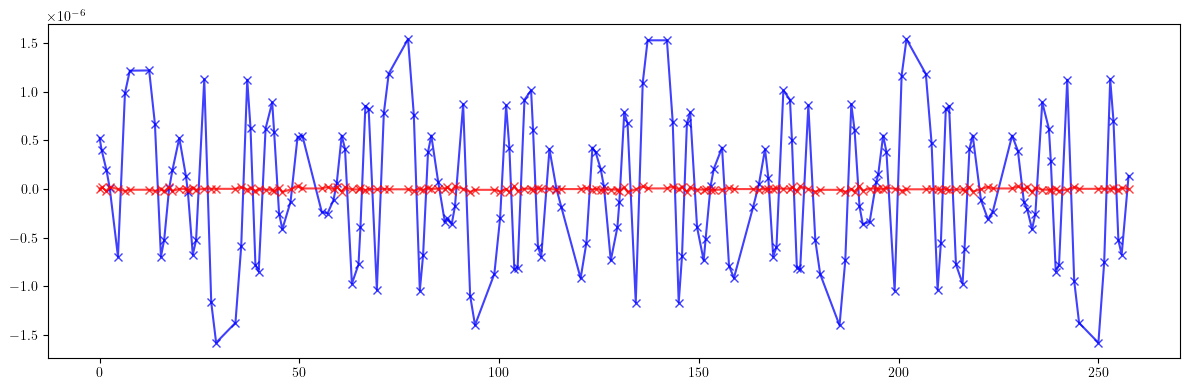

In [26]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

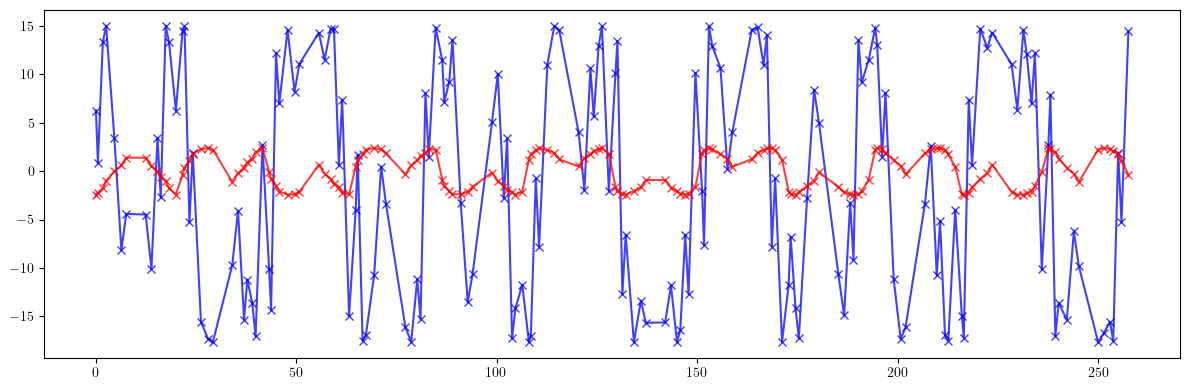

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)


In [27]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())

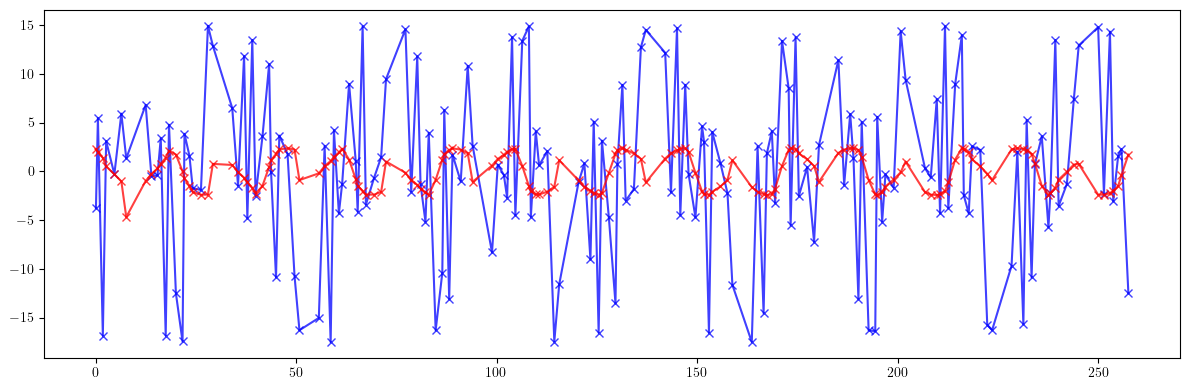

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)


In [28]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())

In [29]:
# Define parametric observable vector

def global_observable(knobs):
    kf, kd = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd])
    return tune(error, [kn], ('kn', None, QF + QD, None), matched=True, limit=1)


def knobs_split(knobs):
    kn, ks = torch.split(knobs, [3, 2])
    kn = Sn @ kn
    ks = Ss @ ks
    return kn, ks


def knobs_build(knobs):
    kn, ks = knobs_split(knobs)
    return (nkn, kn), (nks, ks)


def observable_orm(nn, kn, ns, ks):
    orm = ORM(error, orbit,  [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), limit=1)
    return orm


def observable(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    orm = observable_orm(nn, kn, ns, ks)
    return orm.flatten()

In [30]:
# Check the residual vector norm

global_knobs = torch.tensor(2*[0.0], dtype=dtype)
knobs = torch.tensor((3 + 2)*[0.0], dtype=dtype)

print(((global_observable(global_knobs) - global_target)**2).sum())
print(((observable(knobs) - target)**2).sum())

tensor(0.0008, dtype=torch.float64)
tensor(1498.9104, dtype=torch.float64)


In [31]:
# Optimization loop (local)

# Responce matrix (jacobian)

M = matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

knobs = torch.tensor((3 + 2)*[0.0], dtype=dtype)

# Correction loop

for _ in range(8):
    value = observable(knobs)
    residual = target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    knobs += lr*delta
    print(((value - target)**2).sum())
print()

tensor(1498.9104, dtype=torch.float64)
tensor(94.2315, dtype=torch.float64)
tensor(27.2219, dtype=torch.float64)
tensor(14.5212, dtype=torch.float64)
tensor(11.7324, dtype=torch.float64)
tensor(11.2607, dtype=torch.float64)
tensor(11.2023, dtype=torch.float64)
tensor(11.1988, dtype=torch.float64)



In [32]:
# Apply final corrections

kn, ks = torch.split(knobs, [3, 2])

kn = Sn @ kn
ks = Ss @ ks

error.flatten()

for name, knob in zip(nkn, kn):
    error[name].kn = (error[name].kn + knob).item()
    
for name, knob in zip(nks, ks):
    error[name].ks = (error[name].ks + knob).item()
    
error.splice()

In [33]:
# Compute tunes (fractional part)

nux_result, nuy_result = tune(error, [], matched=True, limit=1)

In [34]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [35]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [36]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [37]:
# Compute coupling

c_result = coupling(error, [])

In [38]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)

tensor(0.0003, dtype=torch.float64)
tensor(0.0002, dtype=torch.float64)



In [39]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_result)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(7.8686e-06, dtype=torch.float64)


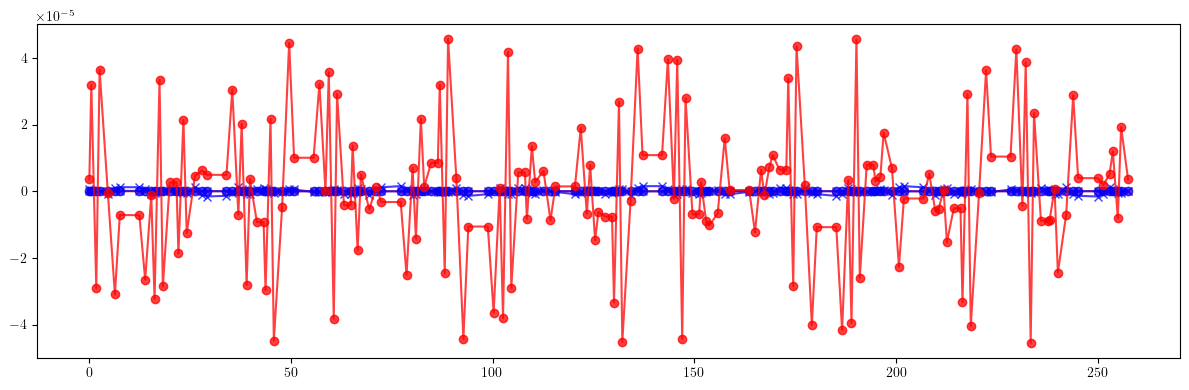

In [40]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

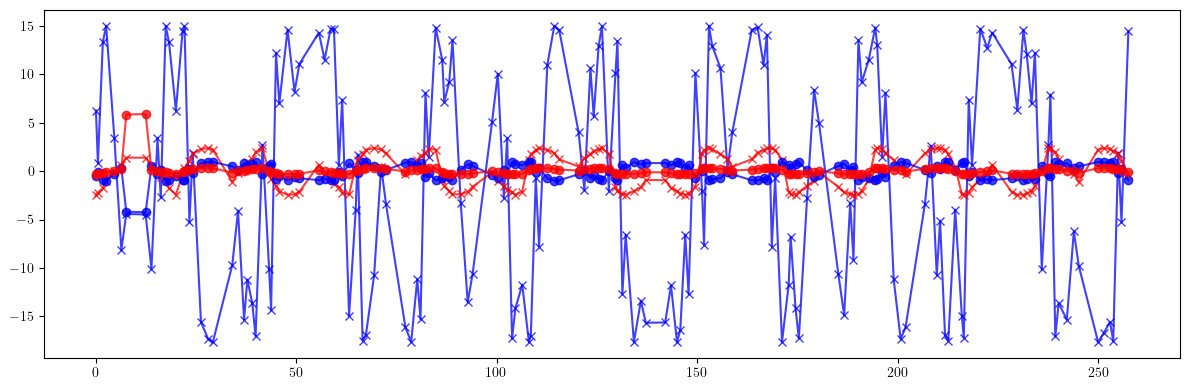

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(0.8181, dtype=torch.float64)
tensor(0.6823, dtype=torch.float64)



In [41]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

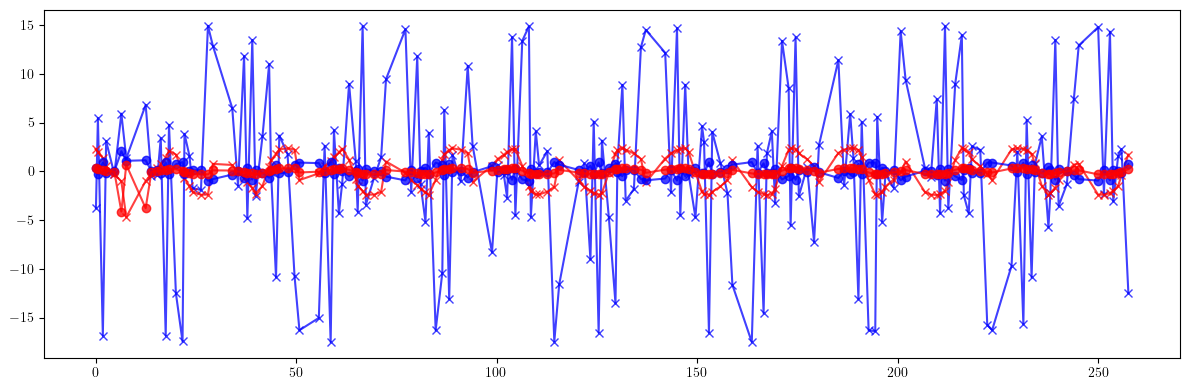

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)

tensor(0.5538, dtype=torch.float64)
tensor(0.4910, dtype=torch.float64)



In [42]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_result)/mux).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_result)/muy).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())
print()

print(100*(((mux - mux_result)/mux)**2).mean().sqrt())
print(100*(((muy - muy_result)/muy)**2).mean().sqrt())
print()

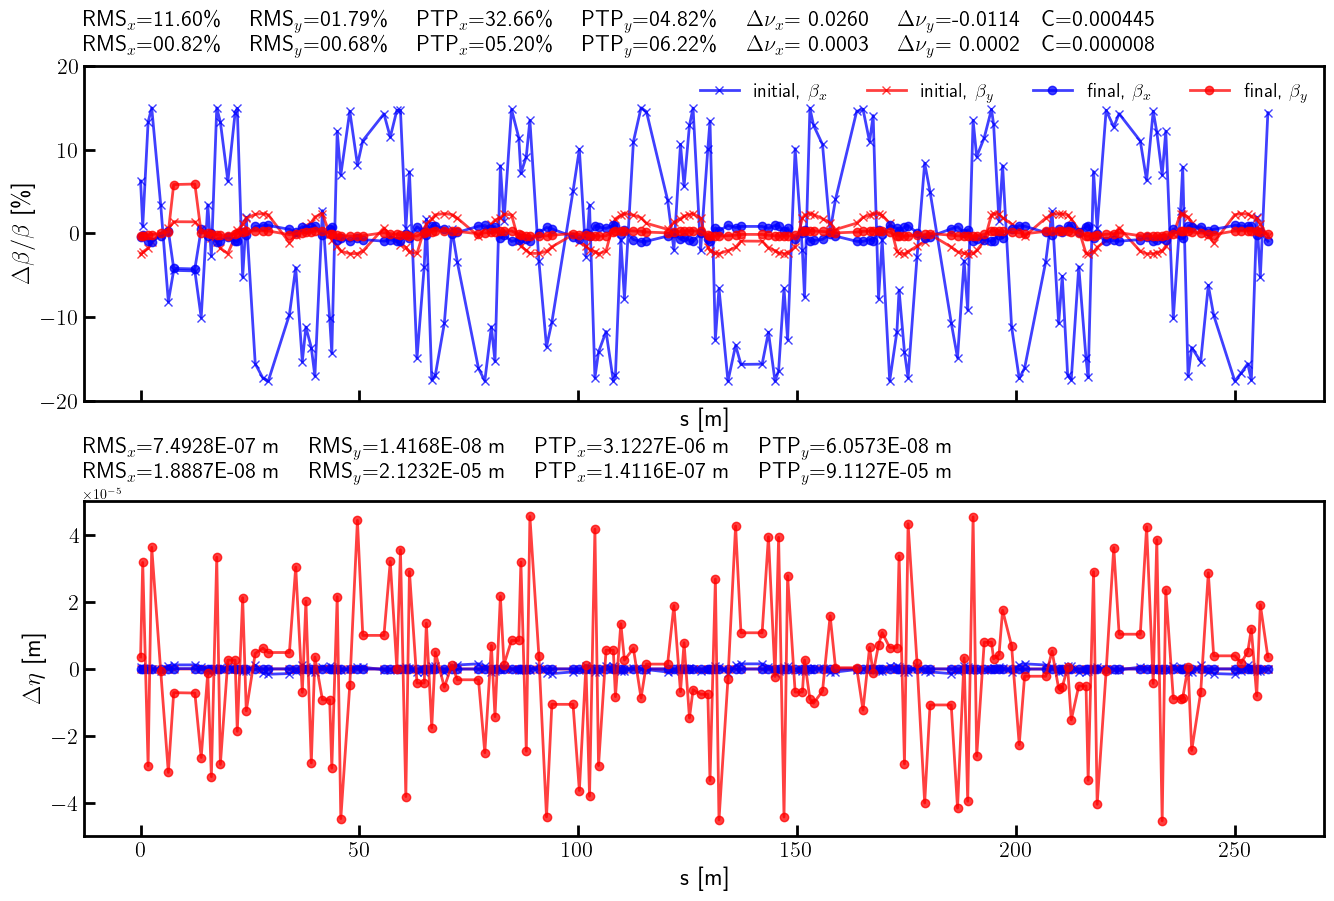

In [43]:
# Beta-beating and dispersion

bx_ref_bb = 100.0*(bx - bx_id)    / bx
by_ref_bb = 100.0*(by - by_id)    / by
bx_res_bb = 100.0*(bx - bx_result)/ bx
by_res_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_ref = rms(bx_ref_bb).item()
ptp_x_ref = (bx_ref_bb.max() - bx_ref_bb.min()).item()
rms_y_ref = rms(by_ref_bb).item()
ptp_y_ref = (by_ref_bb.max() - by_ref_bb.min()).item()

rms_x_res = rms(bx_res_bb).item()
ptp_x_res = (bx_res_bb.max() - bx_res_bb.min()).item()
rms_y_res = rms(by_res_bb).item()
ptp_y_res = (by_res_bb.max() - by_res_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_ref_np = bx_ref_bb.cpu().numpy()
by_ref_np = by_ref_bb.cpu().numpy()
bx_res_np = bx_res_bb.cpu().numpy()
by_res_np = by_res_bb.cpu().numpy()

etax_ref = etaqx - etaqx_id
etay_ref = etaqy - etaqy_id
etax_res = etaqx - etaqx_result
etay_res = etaqy - etaqy_result

rms_etax_ref = rms(etax_ref).item()
ptp_etax_ref = (etax_ref.max() - etax_ref.min()).item()
rms_etay_ref = rms(etay_ref).item()
ptp_etay_ref = (etay_ref.max() - etay_ref.min()).item()

rms_etax_res = rms(etax_res).item()
ptp_etax_res = (etax_res.max() - etax_res.min()).item()
rms_etay_res = rms(etay_res).item()
ptp_etay_res = (etay_res.max() - etay_res.min()).item()

etax_ref_np = etax_ref.cpu().numpy()
etay_ref_np = etay_ref.cpu().numpy()
etax_res_np = etax_res.cpu().numpy()
etay_res_np = etay_res.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'initial, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'initial, $\beta_y$')
ax.errorbar(s, bx_res_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'final, $\beta_x$')
ax.errorbar(s, by_res_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'final, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_id)}{(nux - nux_id).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_id)}{(nuy - nuy_id).abs().item():.4f}'
    rf'\quad C={c_id.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_x_res:05.2f}\% \quad RMS$_y$={rms_y_res:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_res:05.2f}\% \quad PTP$_y$={ptp_y_res:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-20, 20)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'initial, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'initial, $\eta_y$')
ay.errorbar(s, etax_res_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'final, $\eta_x$')
ay.errorbar(s, etay_res_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'final, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_etax_res:.4E} m  \quad RMS$_y$={rms_etay_res:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_res:.4E} m  \quad PTP$_y$={ptp_etay_res:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [44]:
# Optimization loop (global)

# Responce matrix (jacobian)

M = global_matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

global_knobs = torch.tensor(2*[0.0], dtype=dtype)

# Correction loop

for _ in range(1 + 1):
    value = global_observable(global_knobs)
    residual = global_target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    global_knobs += lr*delta
    print(((value - global_target)**2).sum())
print()

tensor(1.1015e-07, dtype=torch.float64)
tensor(9.2994e-09, dtype=torch.float64)



In [45]:
# Apply final corrections

kd, kf = global_knobs

error.flatten()

for name in QF:
    error[name].kn = (error[name].kn + kd).item()

for name in QD:
    error[name].kn = (error[name].kn + kf).item()
    
error.splice()

In [46]:
# Compute tunes (fractional part)

nux_result, nuy_result = tune(error, [], matched=True, limit=1)

In [47]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [48]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [49]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [50]:
# Compute coupling

c_result = coupling(error, [])

In [51]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)

tensor(2.1550e-05, dtype=torch.float64)
tensor(1.7777e-05, dtype=torch.float64)



In [52]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_result)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(7.8723e-06, dtype=torch.float64)


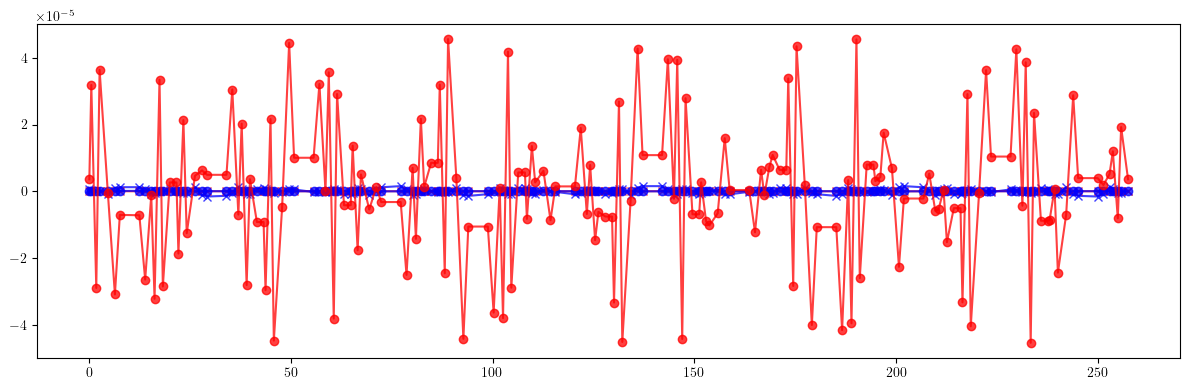

In [53]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

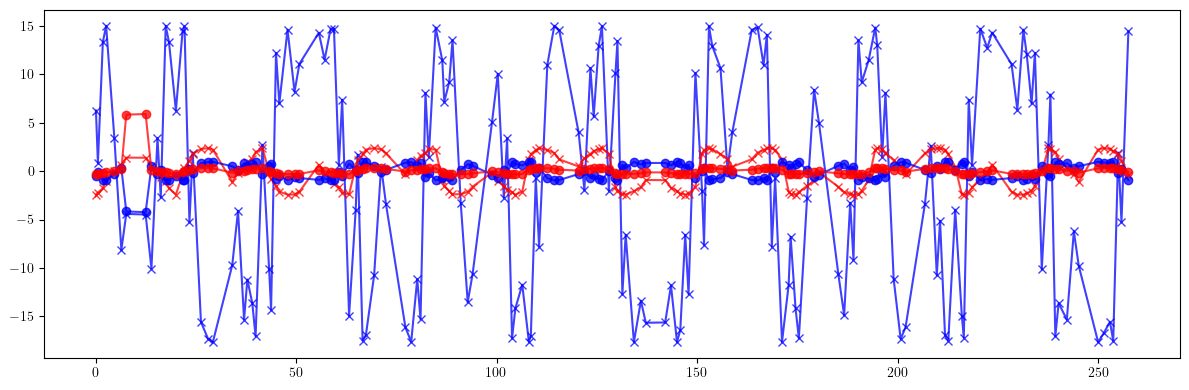

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(0.8132, dtype=torch.float64)
tensor(0.6829, dtype=torch.float64)



In [54]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

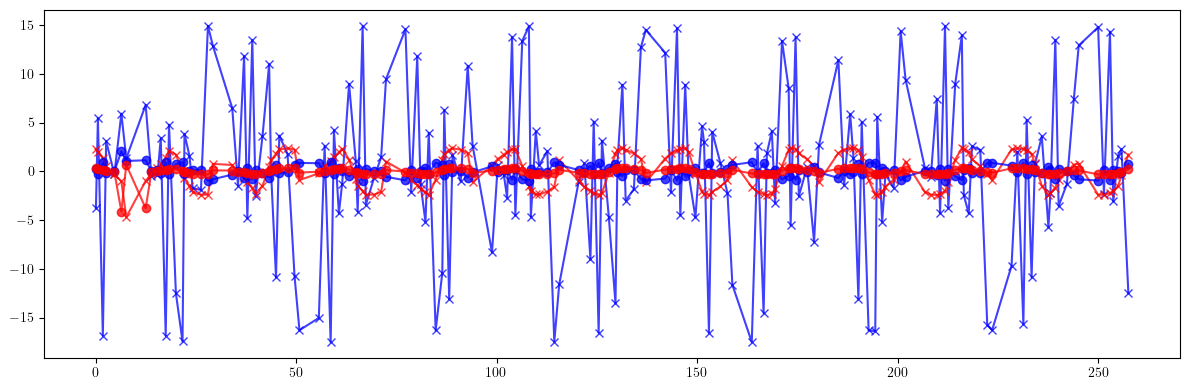

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)

tensor(0.5502, dtype=torch.float64)
tensor(0.4923, dtype=torch.float64)



In [55]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_result)/mux).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_result)/muy).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())
print()

print(100*(((mux - mux_result)/mux)**2).mean().sqrt())
print(100*(((muy - muy_result)/muy)**2).mean().sqrt())
print()

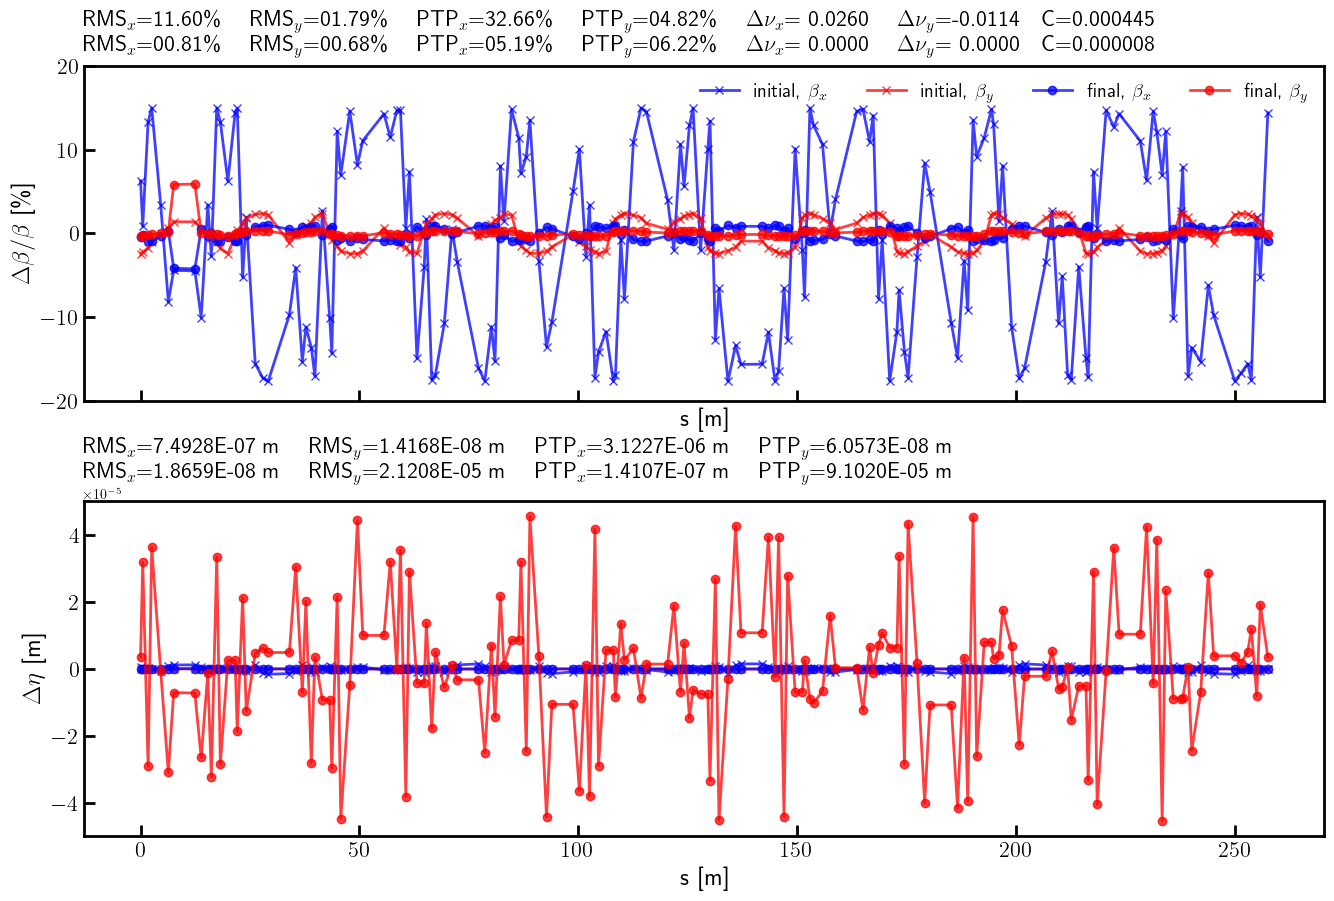

In [56]:
# Beta-beating and dispersion

bx_ref_bb = 100.0*(bx - bx_id)    / bx
by_ref_bb = 100.0*(by - by_id)    / by
bx_res_bb = 100.0*(bx - bx_result)/ bx
by_res_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_ref = rms(bx_ref_bb).item()
ptp_x_ref = (bx_ref_bb.max() - bx_ref_bb.min()).item()
rms_y_ref = rms(by_ref_bb).item()
ptp_y_ref = (by_ref_bb.max() - by_ref_bb.min()).item()

rms_x_res = rms(bx_res_bb).item()
ptp_x_res = (bx_res_bb.max() - bx_res_bb.min()).item()
rms_y_res = rms(by_res_bb).item()
ptp_y_res = (by_res_bb.max() - by_res_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_ref_np = bx_ref_bb.cpu().numpy()
by_ref_np = by_ref_bb.cpu().numpy()
bx_res_np = bx_res_bb.cpu().numpy()
by_res_np = by_res_bb.cpu().numpy()

etax_ref = etaqx - etaqx_id
etay_ref = etaqy - etaqy_id
etax_res = etaqx - etaqx_result
etay_res = etaqy - etaqy_result

rms_etax_ref = rms(etax_ref).item()
ptp_etax_ref = (etax_ref.max() - etax_ref.min()).item()
rms_etay_ref = rms(etay_ref).item()
ptp_etay_ref = (etay_ref.max() - etay_ref.min()).item()

rms_etax_res = rms(etax_res).item()
ptp_etax_res = (etax_res.max() - etax_res.min()).item()
rms_etay_res = rms(etay_res).item()
ptp_etay_res = (etay_res.max() - etay_res.min()).item()

etax_ref_np = etax_ref.cpu().numpy()
etay_ref_np = etay_ref.cpu().numpy()
etax_res_np = etax_res.cpu().numpy()
etay_res_np = etay_res.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'initial, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'initial, $\beta_y$')
ax.errorbar(s, bx_res_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'final, $\beta_x$')
ax.errorbar(s, by_res_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'final, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_id)}{(nux - nux_id).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_id)}{(nuy - nuy_id).abs().item():.4f}'
    rf'\quad C={c_id.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_x_res:05.2f}\% \quad RMS$_y$={rms_y_res:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_res:05.2f}\% \quad PTP$_y$={ptp_y_res:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-20, 20)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'initial, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'initial, $\eta_y$')
ay.errorbar(s, etax_res_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'final, $\eta_x$')
ay.errorbar(s, etay_res_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'final, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_etax_res:.4E} m  \quad RMS$_y$={rms_etay_res:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_res:.4E} m  \quad PTP$_y$={ptp_etay_res:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [57]:
# Knobs

QF = [f'QF_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QD = [f'QD_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]

ring.flatten()

kni = {name: ring[name].kn.item() for name in nkn}
ksi = {name: ring[name].ks.item() for name in nks}
kfi = {name: ring[name].kn.item() for name in QF}
kdi = {name: ring[name].kn.item() for name in QD}

error.flatten()

knf = {name: error[name].kn.item() for name in nkn}
ksf = {name: error[name].ks.item() for name in nks}
kff = {name: error[name].kn.item() for name in QF}
kdf = {name: error[name].kn.item() for name in QD}

dkf = [(kff[name]/kfi[name] - 1) for name in kfi if name not in nkn]
dkd = [(kdf[name]/kdi[name] - 1) for name in kdi if name not in nkn]

dkf, *_ = dkf
dkd, *_ = dkd

dk = {'DKF': dkf, 'DKD': dkd}

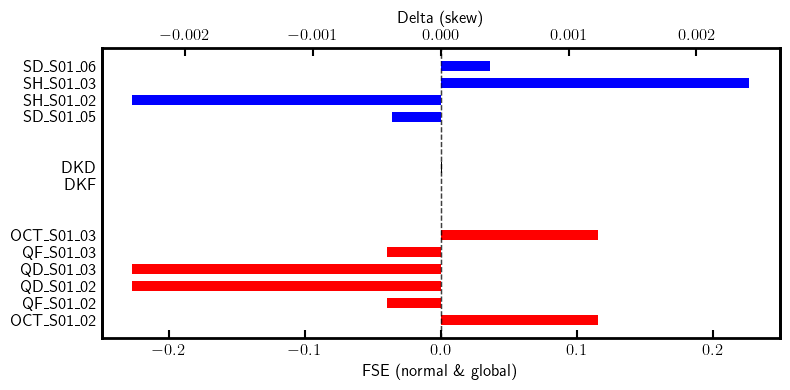

In [58]:
import numpy as np

dkn = np.array([knf[i]/kni[i] - 1 for i in kni])
dks = np.array([ksf[i] - ksi[i] for i in ksi])

n_kn = len(dkn)
n_ks = len(dks)
n_dk = len(dk)

y_kn = np.arange(n_kn)
y_dk = np.arange(n_dk) + n_kn + 2*1
y_ks = np.arange(n_ks) + n_kn + n_dk + 2*2

fig, ax = plt.subplots(figsize=(8, 4))
ay = ax.twiny()

bar_kn = ax.barh(y_kn, dkn, height=0.6, alpha=1, label=r'normal', color='red')
bar_dk = ax.barh(y_dk, list(dk.values()), height=0.6, alpha=1, label=r'global', color='black')
bar_ks = ay.barh(y_ks, dks, height=0.6, alpha=1, label=r'skew', color='blue')

yticks = np.concatenate([y_kn, y_dk, y_ks])
yticklabels = [*kni.keys()] + [*dk.keys()] + [*ksi.keys()]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=12)
ay.set_ylim(ax.get_ylim())
ax.axvline(0.0, color='black', linewidth=1.0, linestyle='--', alpha=0.5)
ay.axvline(0.0, color='black', linewidth=1.0, linestyle='--', alpha=0.5)
xmax = max(np.max(np.abs(dkn)), np.max(np.abs(list(dk.values()))))
ax.set_xlim(-1.1 * xmax, 1.1 * xmax)
xmax = np.max(np.abs(dks))
ay.set_xlim(-1.1 * xmax, 1.1 * xmax)

ax.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
ax.tick_params(axis='y', length=0, width=0, labelsize=12)
ay.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=False, top=True, labelbottom=False, labeltop=True)

ax.set_xlabel(r'FSE (normal \& global)', fontsize=12)
ay.set_xlabel(r'Delta (skew)', fontsize=12)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)
ax.spines['top'].set_visible(False)
ay.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

In [59]:
# Set corrections

dkf = [(kff[name] - kfi[name]) for name in kfi if name not in nkn]
dkd = [(kdf[name] - kdi[name]) for name in kdi if name not in nkn]

dkf, *_ = dkf
dkd, *_ = dkd
dk = {'DKF': dkf, 'DKD': dkd}

dkn = np.array([knf[i] - kni[i] for i in kni])
dks = np.array([ksf[i] - ksi[i] for i in ksi])

dkn = {name: value for name, value in zip(nkn, dkn.tolist())}
dks = {name: value for name, value in zip(nks, dks.tolist())}

In [60]:
# Interaction and feed-forward compensation (several identical IDs)

In [61]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Insert correctors

for name, *_ in ring.layout():
    if name.startswith('CH'):
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector])

# Merge drifts

ring.merge()

# Change lattice start start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice

ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Marker': 12}

In [62]:
# Define ID model
# Note, only the flattened triangular part of the A and B matrices is passed

A = torch.tensor([[-0.03484222052711237, 1.0272120741819959E-7, -4.698931299341201E-9, 0.0015923185492594811],
                  [1.0272120579834892E-7, -0.046082787920135176, 0.0017792061173117564, 3.3551298301095784E-8],
                  [-4.6989312853101E-9, 0.0017792061173117072, 0.056853750760983084, -1.5929605363332683E-7],
                  [0.0015923185492594336, 3.3551298348653296E-8, -1.5929605261642905E-7, 0.08311631737263032]], dtype=dtype)

B = torch.tensor([[0.03649353186115209, 0.0015448347221877217, 0.00002719892025520868, -0.0033681183134964482],
                  [0.0015448347221877217, 0.13683886657005795, -0.0033198692682377406, 0.00006140578258682469],
                  [0.00002719892025520868, -0.0033198692682377406, -0.05260095308967722, 0.005019907688182885],
                  [-0.0033681183134964482, 0.00006140578258682469, 0.005019907688182885, -0.2531573249456863]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [63]:
# Insert IDs into the existing lattice

# List of ID markers

sections = ['S01', 'S03', 'S05', 'S07', 'S09', 'S11']

names = [f'MLL_{section}' for section in sections]

error = ring.clone()
error.flatten()
for name in names:
    error.insert(ID, name, position=0.0)
error.splice()

# Describe

error.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Matrix': 1,
 'Marker': 6}

In [64]:
# Apply final corrections (local)

kn = torch.tensor([*dkn.values()], dtype=dtype)
ks = torch.tensor([*dks.values()], dtype=dtype)

error.flatten()

for section in sections:

    names = [f'OCT_{section}_02', f'QF_{section}_02', f'QD_{section}_02', f'QD_{section}_03', f'QF_{section}_03', f'OCT_{section}_03']
    for name, knob in zip(names, kn):
        error[name].kn = (error[name].kn + knob).item()

    names = [f'SD_{section}_05', f'SH_{section}_02', f'SH_{section}_03', f'SD_{section}_06']
    for name, knob in zip(names, ks):
        error[name].ks = (error[name].ks + knob).item()
    
error.splice()

In [65]:
# Compute tunes (fractional part)

nux_result, nuy_result = tune(error, [], matched=True, limit=1)

In [66]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [67]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [68]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [69]:
# Compute coupling

c_result = coupling(error, [])

In [70]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)

tensor(0.0014, dtype=torch.float64)
tensor(0.0013, dtype=torch.float64)



In [71]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_result)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(2.5498e-05, dtype=torch.float64)


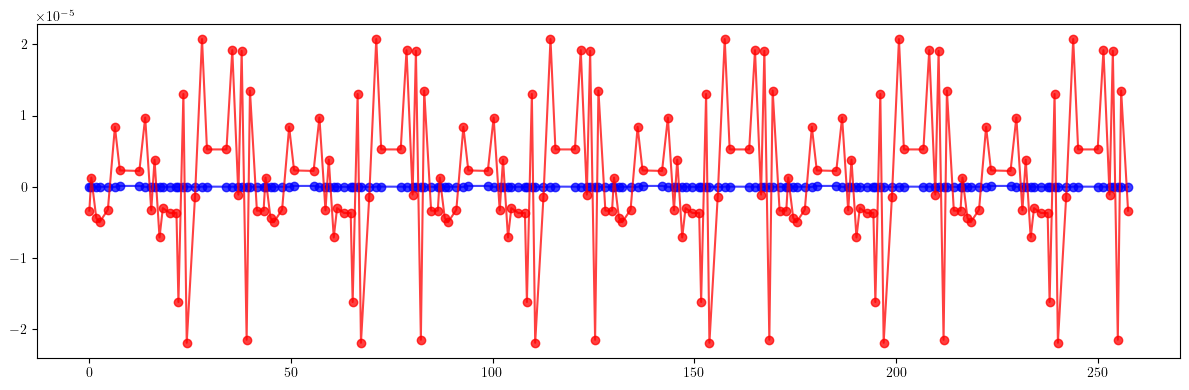

In [72]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

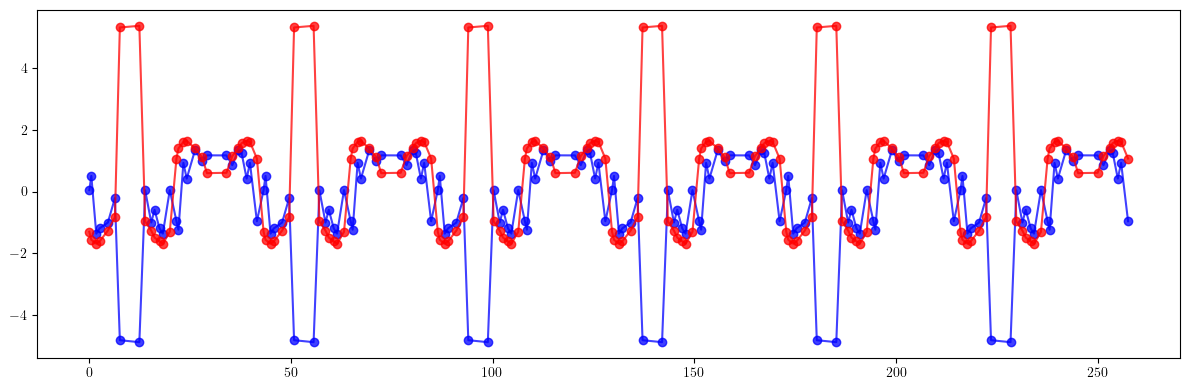

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(1.5971, dtype=torch.float64)
tensor(1.9439, dtype=torch.float64)



In [73]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

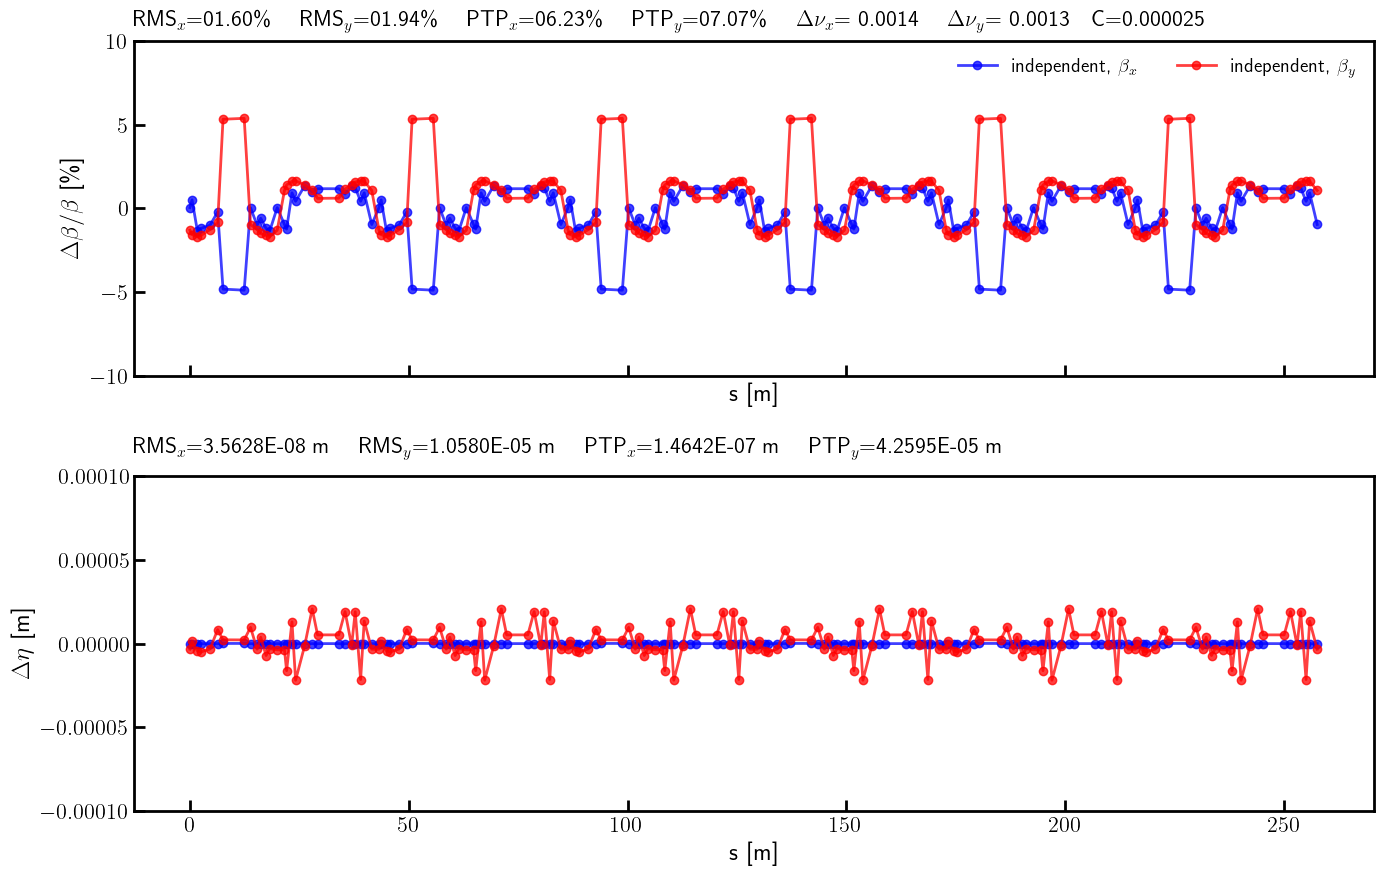

In [74]:
# Beta-beating and dispersion

bx_ref_bb = 100.0*(bx - bx_result)/ bx
by_ref_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_ref = rms(bx_ref_bb).item()
ptp_x_ref = (bx_ref_bb.max() - bx_ref_bb.min()).item()
rms_y_ref = rms(by_ref_bb).item()
ptp_y_ref = (by_ref_bb.max() - by_ref_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_ref_np = bx_ref_bb.cpu().numpy()
by_ref_np = by_ref_bb.cpu().numpy()

etax_ref = etaqx - etaqx_result
etay_ref = etaqy - etaqy_result

rms_etax_ref = rms(etax_ref).item()
ptp_etax_ref = (etax_ref.max() - etax_ref.min()).item()
rms_etay_ref = rms(etay_ref).item()
ptp_etay_ref = (etay_ref.max() - etay_ref.min()).item()

etax_ref_np = etax_ref.cpu().numpy()
etay_ref_np = etay_ref.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'independent, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-10, 10)

ay.errorbar(s, etax_ref_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'independent, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'independent, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m  \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m  \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ay.set_ylim(-1E-4, +1E-4)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [75]:
# Apply final corrections  (global)

kd, kf = torch.tensor([*dk.values()], dtype=dtype)

error.flatten()

for section in sections:

    names = [f'OCT_{section}_02', f'QF_{section}_02', f'QD_{section}_02', f'QD_{section}_03', f'QF_{section}_03', f'OCT_{section}_03']

    for name in QF:
        if name not in names:
            error[name].kn = (error[name].kn + kd).item()
    
    for name in QD:
        if name not in names:
            error[name].kn = (error[name].kn + kf).item()
    
error.splice()

In [76]:
# Compute tunes (fractional part)

nux_result, nuy_result = tune(error, [], matched=True, limit=1)

In [77]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [78]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [79]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [80]:
# Compute coupling

c_result = coupling(error, [])

In [81]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)

tensor(0.0005, dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)



In [82]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_result)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(2.5618e-05, dtype=torch.float64)


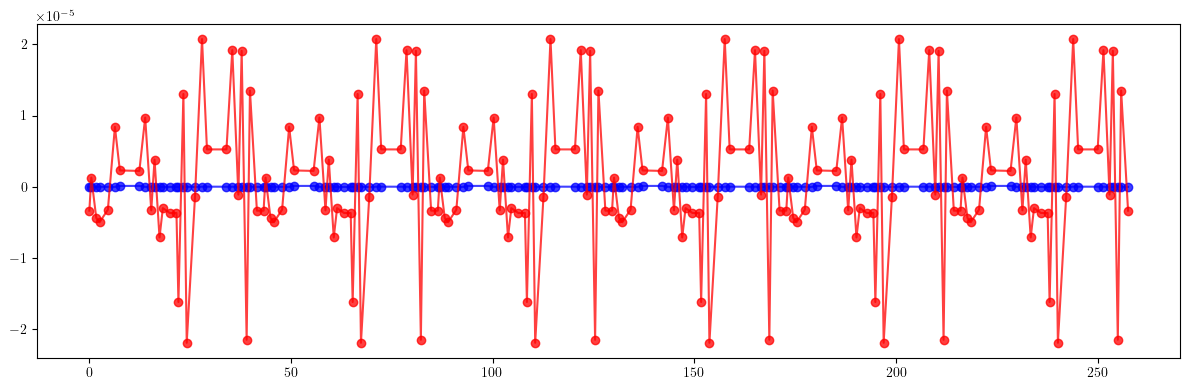

In [83]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

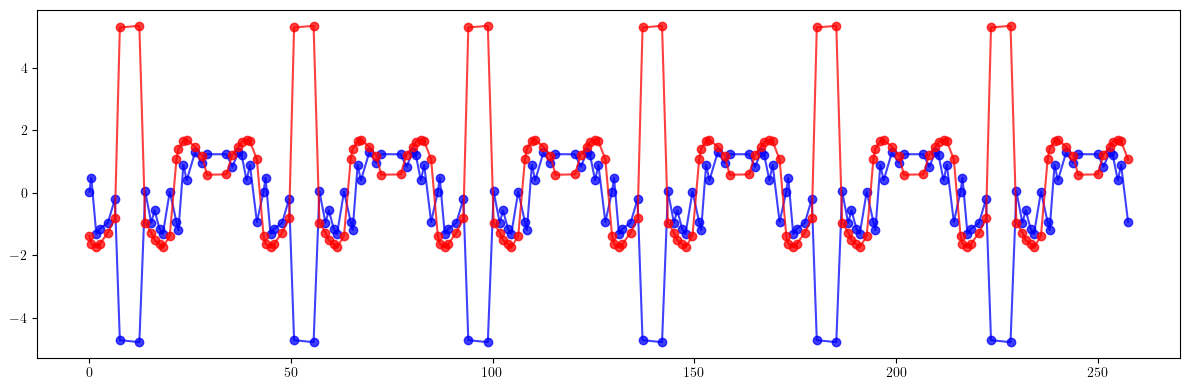

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(1.5585, dtype=torch.float64)
tensor(1.9619, dtype=torch.float64)



In [84]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

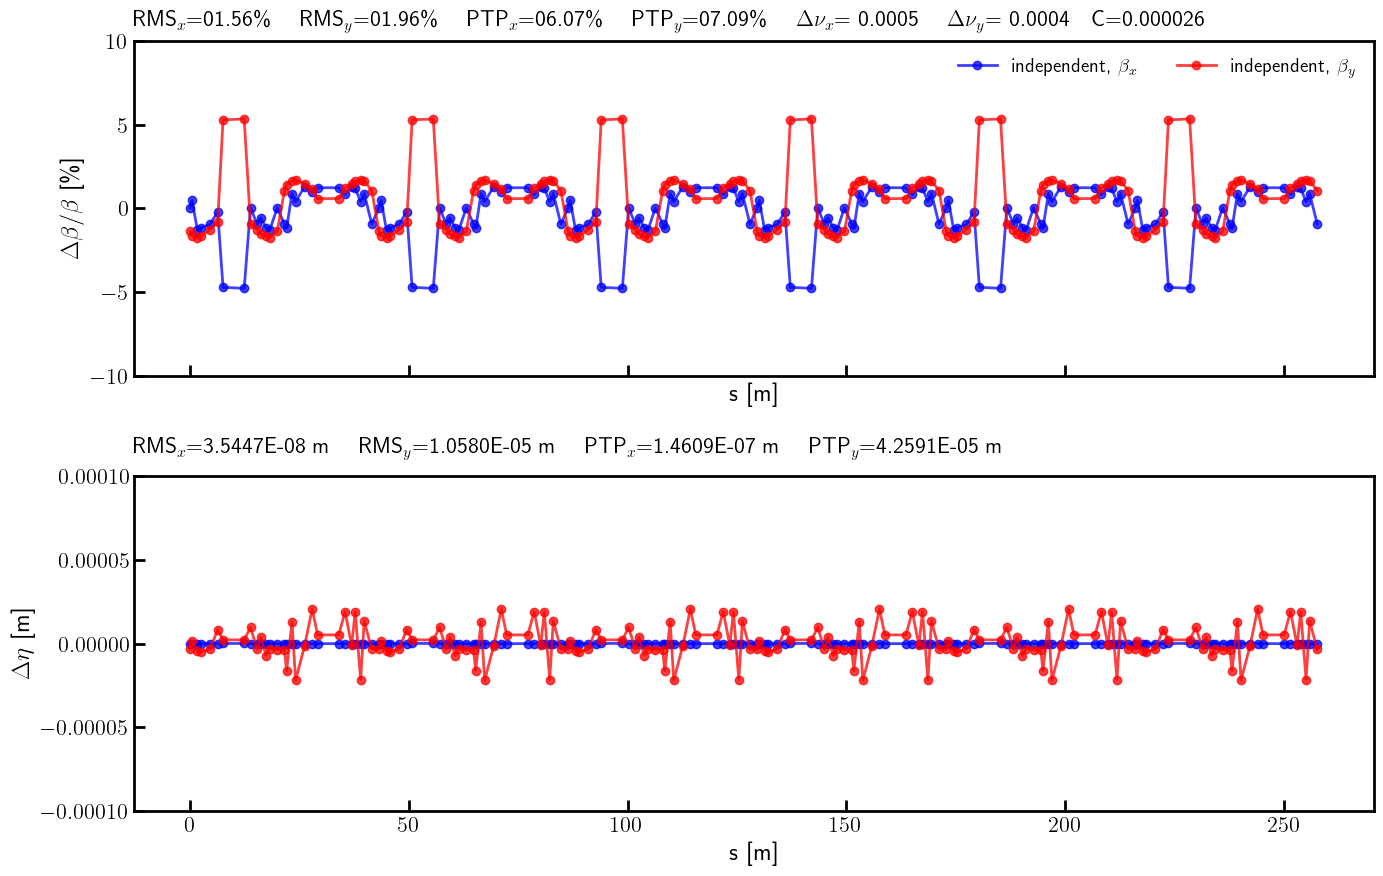

In [85]:
# Beta-beating and dispersion

bx_ref_bb = 100.0*(bx - bx_result)/ bx
by_ref_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_ref = rms(bx_ref_bb).item()
ptp_x_ref = (bx_ref_bb.max() - bx_ref_bb.min()).item()
rms_y_ref = rms(by_ref_bb).item()
ptp_y_ref = (by_ref_bb.max() - by_ref_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_ref_np = bx_ref_bb.cpu().numpy()
by_ref_np = by_ref_bb.cpu().numpy()

etax_ref = etaqx - etaqx_result
etay_ref = etaqy - etaqy_result

rms_etax_ref = rms(etax_ref).item()
ptp_etax_ref = (etax_ref.max() - etax_ref.min()).item()
rms_etay_ref = rms(etay_ref).item()
ptp_etay_ref = (etay_ref.max() - etay_ref.min()).item()

etax_ref_np = etax_ref.cpu().numpy()
etay_ref_np = etay_ref.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'independent, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-10, 10)

ay.errorbar(s, etax_ref_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'independent, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'independent, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m  \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m  \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ay.set_ylim(-1E-4, +1E-4)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [86]:
# Global tune correction

# Responce matrix (jacobian)

M = global_matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

global_knobs = torch.tensor(2*[0.0], dtype=dtype)

# Correction loop

for _ in range(1 + 1):
    value = global_observable(global_knobs)
    residual = global_target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    global_knobs += lr*delta
    print(((value - global_target)**2).sum())
print()

tensor(4.6030e-07, dtype=torch.float64)
tensor(1.0884e-07, dtype=torch.float64)



In [87]:
# Apply final corrections

kd, kf = global_knobs

error.flatten()

for name in QF:
    error[name].kn = (error[name].kn + kd).item()

for name in QD:
    error[name].kn = (error[name].kn + kf).item()
    
error.splice()

In [88]:
# Compute tunes (fractional part)

nux_result, nuy_result = tune(error, [], matched=True, limit=1)

In [89]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [90]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [91]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [92]:
# Compute coupling

c_result = coupling(error, [])

In [93]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)

tensor(0.0001, dtype=torch.float64)
tensor(9.4279e-05, dtype=torch.float64)



In [94]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_result)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(2.5678e-05, dtype=torch.float64)


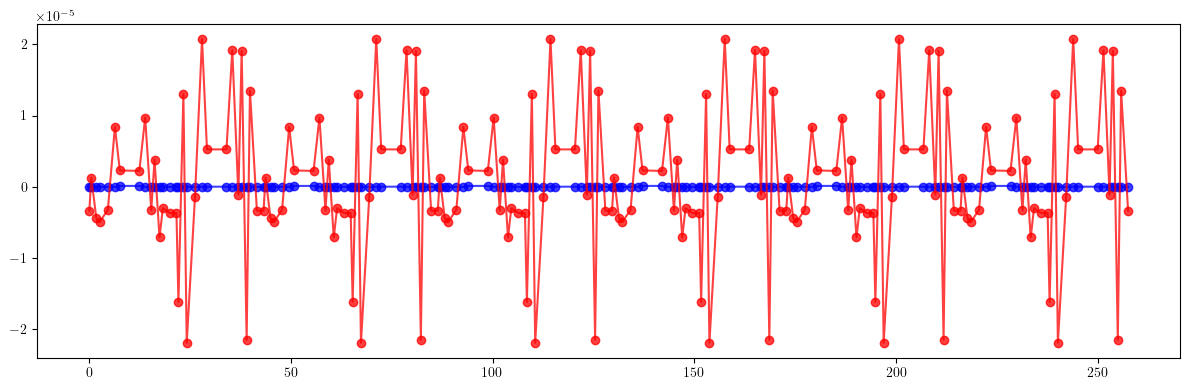

In [95]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

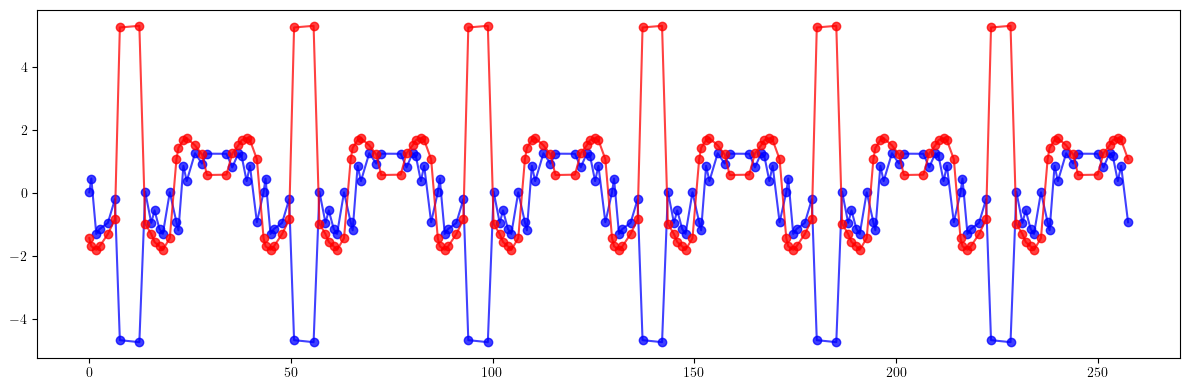

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(1.5408, dtype=torch.float64)
tensor(1.9816, dtype=torch.float64)



In [96]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

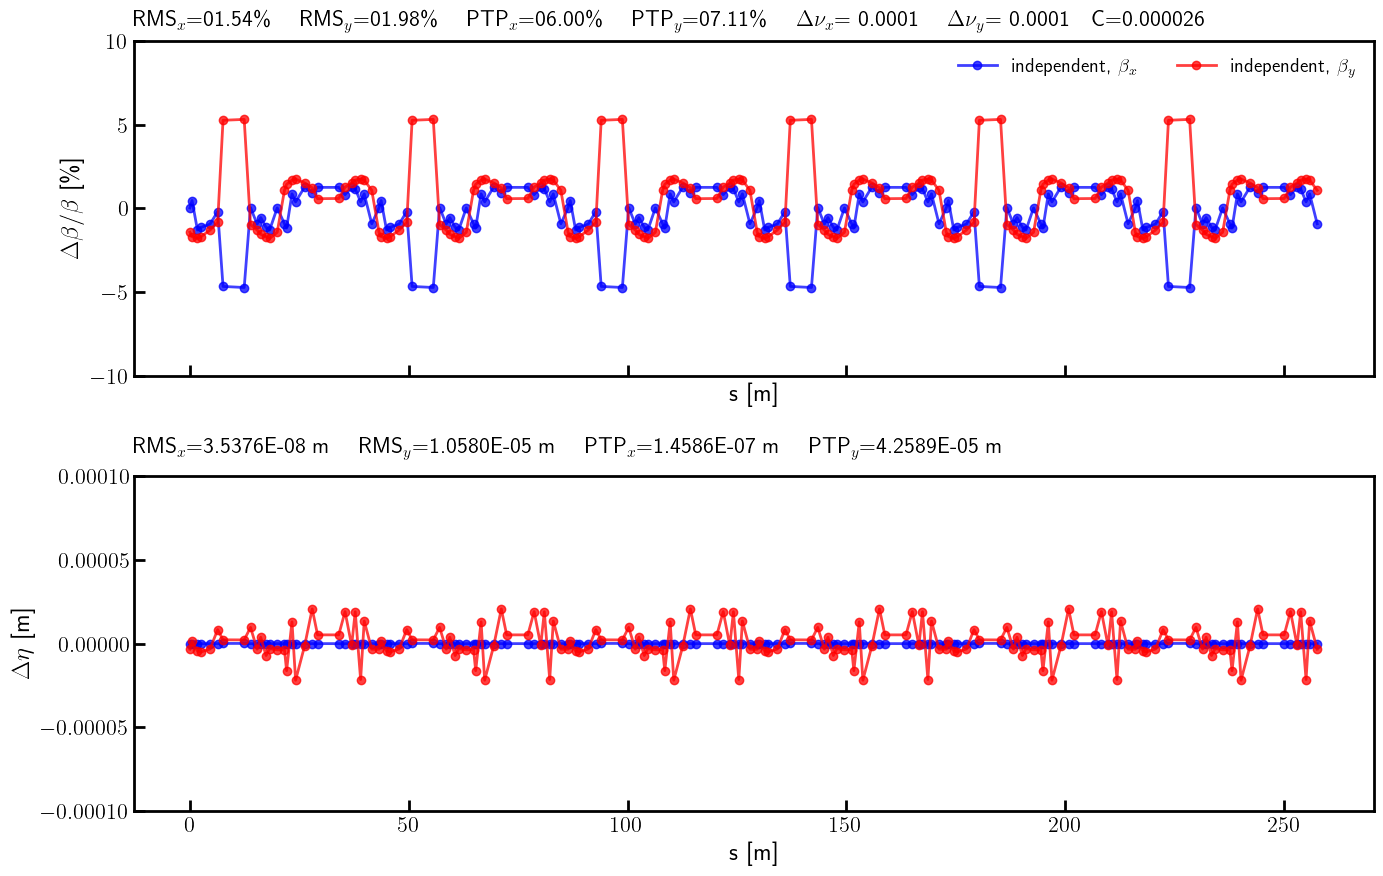

In [97]:
# Beta-beating and dispersion

bx_ref_bb = 100.0*(bx - bx_result)/ bx
by_ref_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_ref = rms(bx_ref_bb).item()
ptp_x_ref = (bx_ref_bb.max() - bx_ref_bb.min()).item()
rms_y_ref = rms(by_ref_bb).item()
ptp_y_ref = (by_ref_bb.max() - by_ref_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_ref_np = bx_ref_bb.cpu().numpy()
by_ref_np = by_ref_bb.cpu().numpy()

etax_ref = etaqx - etaqx_result
etay_ref = etaqy - etaqy_result

rms_etax_ref = rms(etax_ref).item()
ptp_etax_ref = (etax_ref.max() - etax_ref.min()).item()
rms_etay_ref = rms(etay_ref).item()
ptp_etay_ref = (etay_ref.max() - etay_ref.min()).item()

etax_ref_np = etax_ref.cpu().numpy()
etay_ref_np = etay_ref.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'independent, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-10, 10)

ay.errorbar(s, etax_ref_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'independent, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'independent, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m  \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m  \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ay.set_ylim(-1E-4, +1E-4)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [98]:
# In the above corrections are applied independently ignoring interaction between IDs
# Only additional global tune correction is performed
# Next, we adjust all local correctors for straights with IDs and try to correct the residual errors
# This result corresponds to accounting for interaction of IDs after feed forward using local knobs

In [99]:
# Local knobs

# Normal quadrupole correctors

nkn = []
for section in sections:
    nkn.extend([f'OCT_{section}_02', f'QF_{section}_02', f'QD_{section}_02', f'QD_{section}_03', f'QF_{section}_03', f'OCT_{section}_03'])

# Skew quadrupole correctors

nks = []
for section in sections:
    nks.extend([f'SD_{section}_05', f'SH_{section}_02', f'SH_{section}_03', f'SD_{section}_06'])

In [100]:
# Define knobs to magnets mixing matrices

Sn = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]], dtype=dtype)
Sn = torch.block_diag(*[Sn]*len(sections))

Ss = torch.tensor([[+1.0, 0.0], [0.0, +1.0], [0.0, -1.0], [-1.0, 0.0]], dtype=dtype)
Ss = torch.block_diag(*[Ss]*len(sections))

In [101]:
# Define observables for 'mixed' knobs

def knobs_split(knobs):
    kn, ks = torch.split(knobs, [3*len(sections), 2*len(sections)])
    kn = Sn @ kn
    ks = Ss @ ks
    return kn, ks


def knobs_build(knobs):
    kn, ks = knobs_split(knobs)
    return (nkn, kn), (nks, ks)


def observable_orm(nn, kn, ns, ks):
    orm = ORM(ring, orbit,  [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), limit=1)
    return orm


def observable(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    orm = observable_orm(nn, kn, ns, ks)
    return orm.flatten()


knobs = torch.tensor((3*len(sections) + 2*len(sections))*[0.0], dtype=dtype)
print((target := observable(knobs)).shape)
print((matrix := torch.func.jacfwd(observable)(knobs)).shape)

torch.Size([16128])
torch.Size([16128, 30])


In [102]:
# Define parametric observable vector

def global_observable(knobs):
    kf, kd = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd])
    return tune(error, [kn], ('kn', None, QF + QD, None), matched=True, limit=1)


def knobs_split(knobs):
    kn, ks = torch.split(knobs, [3*len(sections), 2*len(sections)])
    kn = Sn @ kn
    ks = Ss @ ks
    return kn, ks

def knobs_build(knobs):
    kn, ks = knobs_split(knobs)
    return (nkn, kn), (nks, ks)


def observable_orm(nn, kn, ns, ks):
    orm = ORM(error, orbit,  [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), limit=1)
    return orm


def observable(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    orm = observable_orm(nn, kn, ns, ks)
    return orm.flatten()

In [103]:
# Check the residual vector norm

global_knobs = torch.tensor(2*[0.0], dtype=dtype)
knobs = torch.tensor((3*len(sections) + 2*len(sections))*[0.0], dtype=dtype)

print(((global_observable(global_knobs) - global_target)**2).sum())
print(((observable(knobs) - target)**2).sum())

tensor(2.5230e-08, dtype=torch.float64)
tensor(72.0633, dtype=torch.float64)


In [104]:
# Optimization loop (local)

# Responce matrix (jacobian)

M = matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.25

# Initial value

knobs = torch.tensor((3*len(sections) + 2*len(sections))*[0.0], dtype=dtype)

# Correction loop

for _ in range(16):
    value = observable(knobs)
    residual = target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    knobs += lr*delta
    print(((value - target)**2).sum())
print()

tensor(72.0633, dtype=torch.float64)
tensor(62.4642, dtype=torch.float64)
tensor(56.3696, dtype=torch.float64)
tensor(52.4136, dtype=torch.float64)
tensor(49.8094, dtype=torch.float64)
tensor(48.0831, dtype=torch.float64)
tensor(46.9374, dtype=torch.float64)
tensor(46.1793, dtype=torch.float64)
tensor(45.6810, dtype=torch.float64)
tensor(45.3563, dtype=torch.float64)
tensor(45.1470, dtype=torch.float64)
tensor(45.0138, dtype=torch.float64)
tensor(44.9305, dtype=torch.float64)
tensor(44.8793, dtype=torch.float64)
tensor(44.8486, dtype=torch.float64)
tensor(44.8309, dtype=torch.float64)



In [105]:
# Apply final corrections

kn, ks = torch.split(knobs, [3*len(sections), 2*len(sections)])

kn = Sn @ kn
ks = Ss @ ks

error.flatten()

for name, knob in zip(nkn, kn):
    error[name].kn = (error[name].kn + knob).item()
    
for name, knob in zip(nks, ks):
    error[name].ks = (error[name].ks + knob).item()
    
error.splice()

In [106]:
# Compute tunes (fractional part)

nux_final, nuy_final = tune(error, [], matched=True, limit=1)

In [107]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [108]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [109]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [110]:
# Compute coupling

c_final = coupling(error, [])

In [111]:
# Tune shifts

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

print((nux - nux_final).abs())
print((nuy - nuy_final).abs())
print()

tensor(0.0001, dtype=torch.float64)
tensor(9.4279e-05, dtype=torch.float64)

tensor(0.0026, dtype=torch.float64)
tensor(0.0027, dtype=torch.float64)



In [112]:
# Coupling (minimal tune distance)

print(c)
print(c_result)
print(c_final)

tensor(0., dtype=torch.float64)
tensor(2.5678e-05, dtype=torch.float64)
tensor(1.7328e-05, dtype=torch.float64)


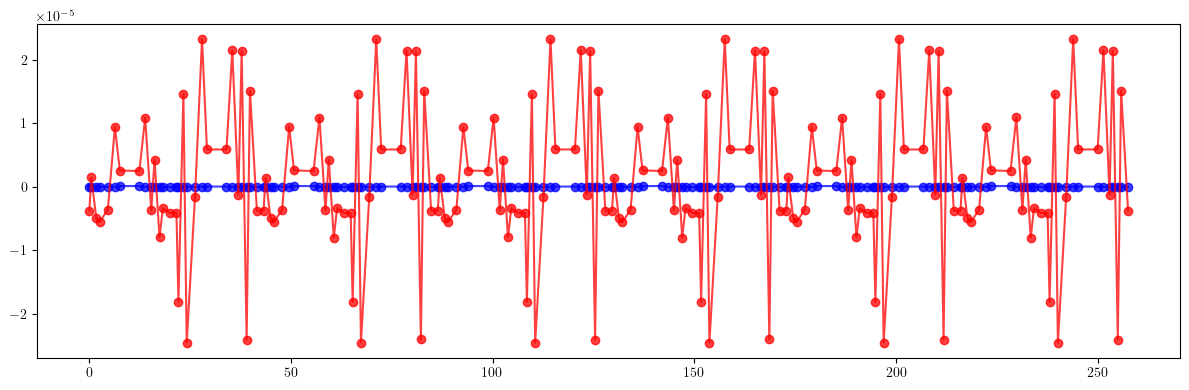

In [113]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

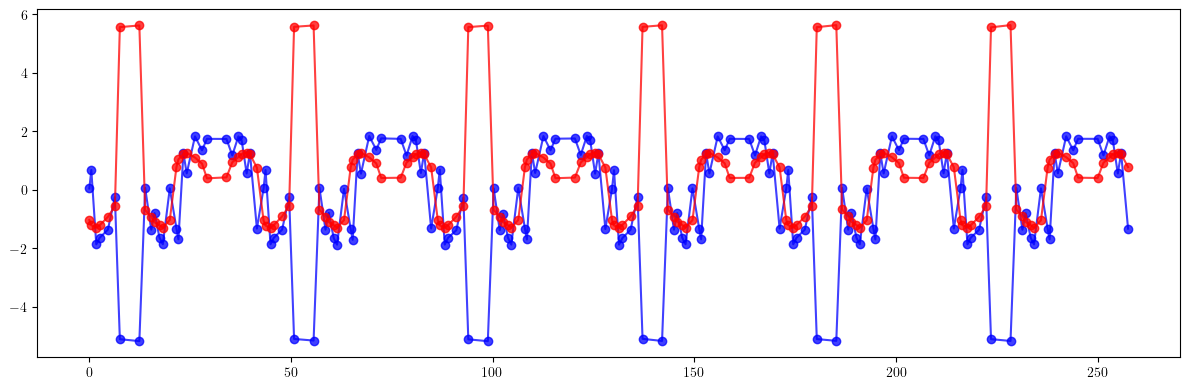

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(1.8806, dtype=torch.float64)
tensor(1.7984, dtype=torch.float64)



In [114]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

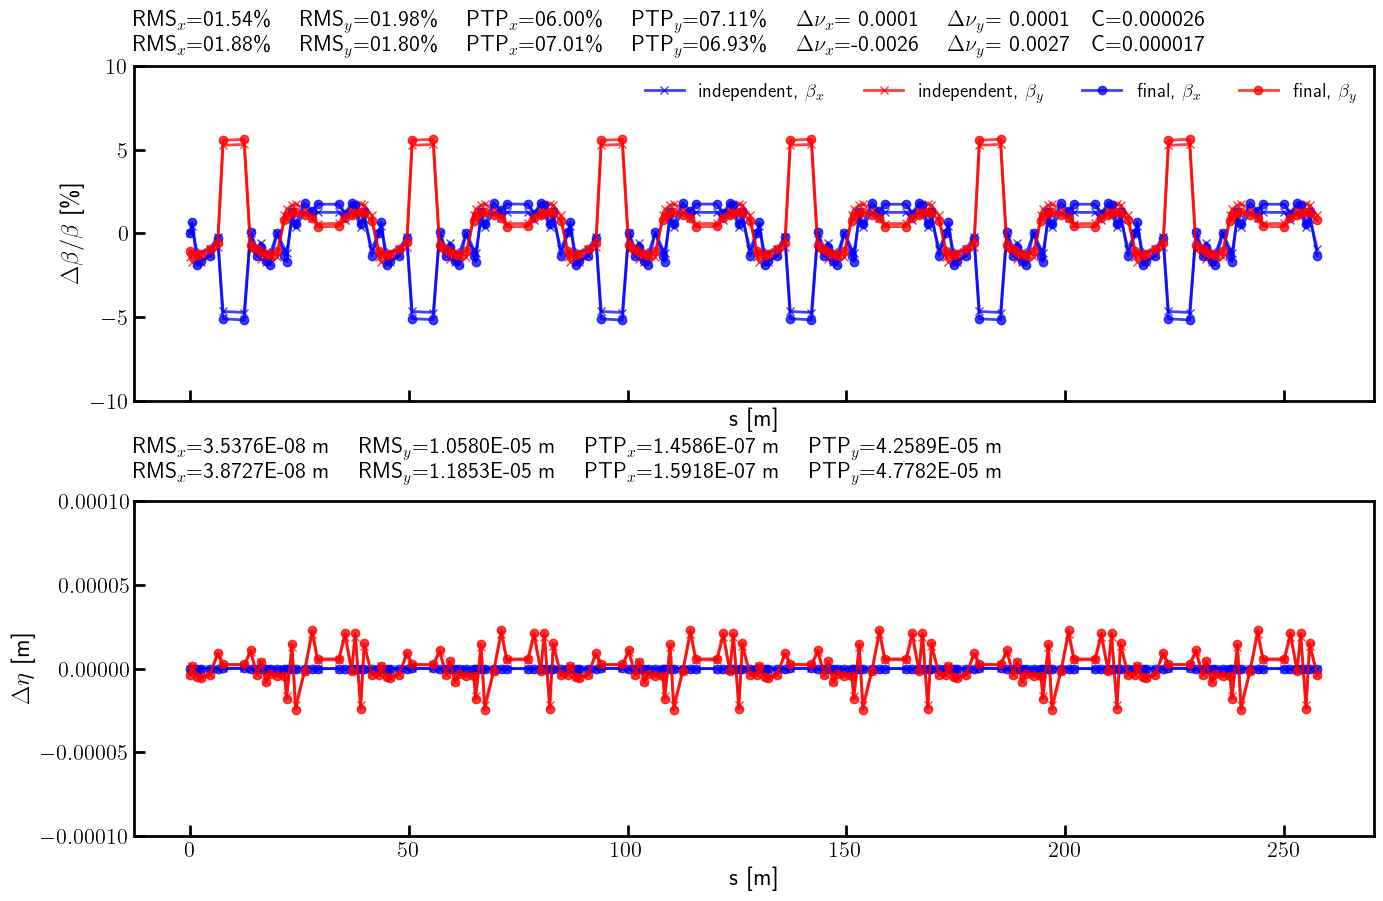

In [115]:
# Beta-beating and dispersion

bx_res_bb = 100.0*(bx - bx_result)/ bx
by_res_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_res = rms(bx_res_bb).item()
ptp_x_res = (bx_res_bb.max() - bx_res_bb.min()).item()
rms_y_res = rms(by_res_bb).item()
ptp_y_res = (by_res_bb.max() - by_res_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_res_np = bx_res_bb.cpu().numpy()
by_res_np = by_res_bb.cpu().numpy()

etax_res = etaqx - etaqx_result
etay_res = etaqy - etaqy_result

rms_etax_res = rms(etax_res).item()
ptp_etax_res = (etax_res.max() - etax_res.min()).item()
rms_etay_res = rms(etay_res).item()
ptp_etay_res = (etay_res.max() - etay_res.min()).item()

etax_res_np = etax_res.cpu().numpy()
etay_res_np = etay_res.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'independent, $\beta_y$')
ax.errorbar(s, bx_res_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'final, $\beta_x$')
ax.errorbar(s, by_res_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'final, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_x_res:05.2f}\% \quad RMS$_y$={rms_y_res:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_res:05.2f}\% \quad PTP$_y$={ptp_y_res:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_final)}{(nux - nux_final).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_final)}{(nuy - nuy_final).abs().item():.4f}'
    rf'\quad C={c_final.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-10, 10)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'independent, $\eta_y$')
ay.errorbar(s, etax_res_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'final, $\eta_x$')
ay.errorbar(s, etay_res_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'final, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_etax_res:.4E} m  \quad RMS$_y$={rms_etay_res:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_res:.4E} m  \quad PTP$_y$={ptp_etay_res:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ay.set_ylim(-1E-4, +1E-4)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [116]:
# Optimization loop (global)

# Responce matrix (jacobian)

M = global_matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

global_knobs = torch.tensor(2*[0.0], dtype=dtype)

# Correction loop

for _ in range(4):
    value = global_observable(global_knobs)
    residual = global_target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    global_knobs += lr*delta
    print(((value - global_target)**2).sum())
print()

tensor(1.4061e-05, dtype=torch.float64)
tensor(9.1057e-07, dtype=torch.float64)
tensor(9.8101e-08, dtype=torch.float64)
tensor(2.0018e-08, dtype=torch.float64)



In [117]:
# Apply final corrections

kd, kf = global_knobs

error.flatten()

for name in QF:
    error[name].kn = (error[name].kn + kd).item()

for name in QD:
    error[name].kn = (error[name].kn + kf).item()
    
error.splice()

In [118]:
# Compute tunes (fractional part)

nux_final, nuy_final = tune(error, [], matched=True, limit=1)

In [119]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [120]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [121]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [122]:
# Compute coupling

c_final = coupling(error, [])

In [123]:
# Tune shifts

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

print((nux - nux_final).abs())
print((nuy - nuy_final).abs())
print()

tensor(0.0001, dtype=torch.float64)
tensor(9.4279e-05, dtype=torch.float64)

tensor(4.7896e-05, dtype=torch.float64)
tensor(5.2051e-05, dtype=torch.float64)



In [124]:
# Coupling (minimal tune distance)

print(c)
print(c_result)
print(c_final)

tensor(0., dtype=torch.float64)
tensor(2.5678e-05, dtype=torch.float64)
tensor(1.6394e-05, dtype=torch.float64)


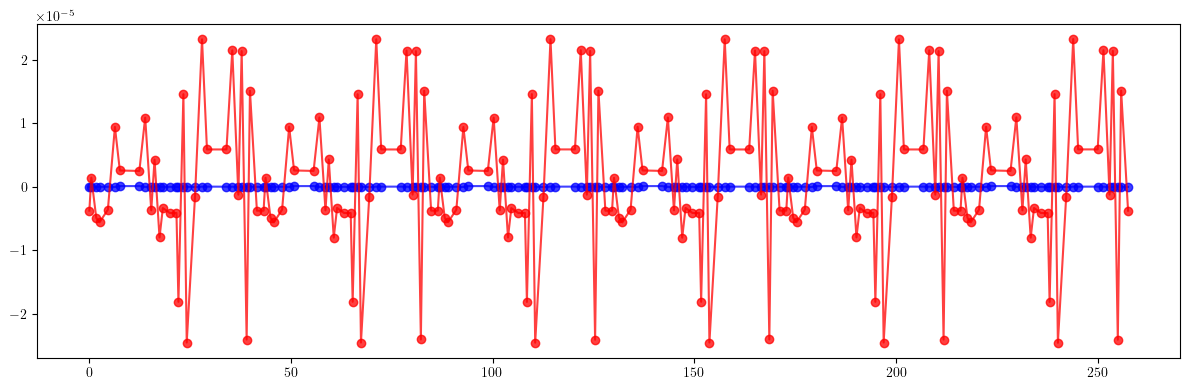

In [125]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

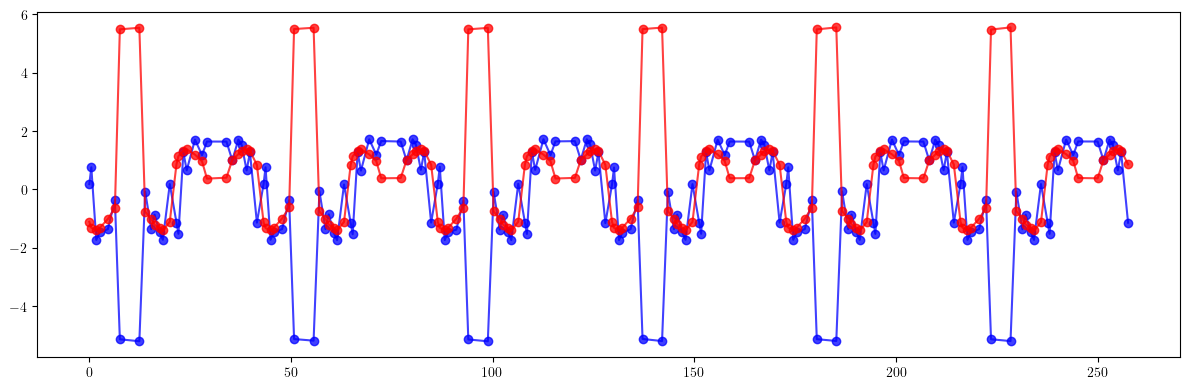

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(1.8283, dtype=torch.float64)
tensor(1.8272, dtype=torch.float64)



In [126]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

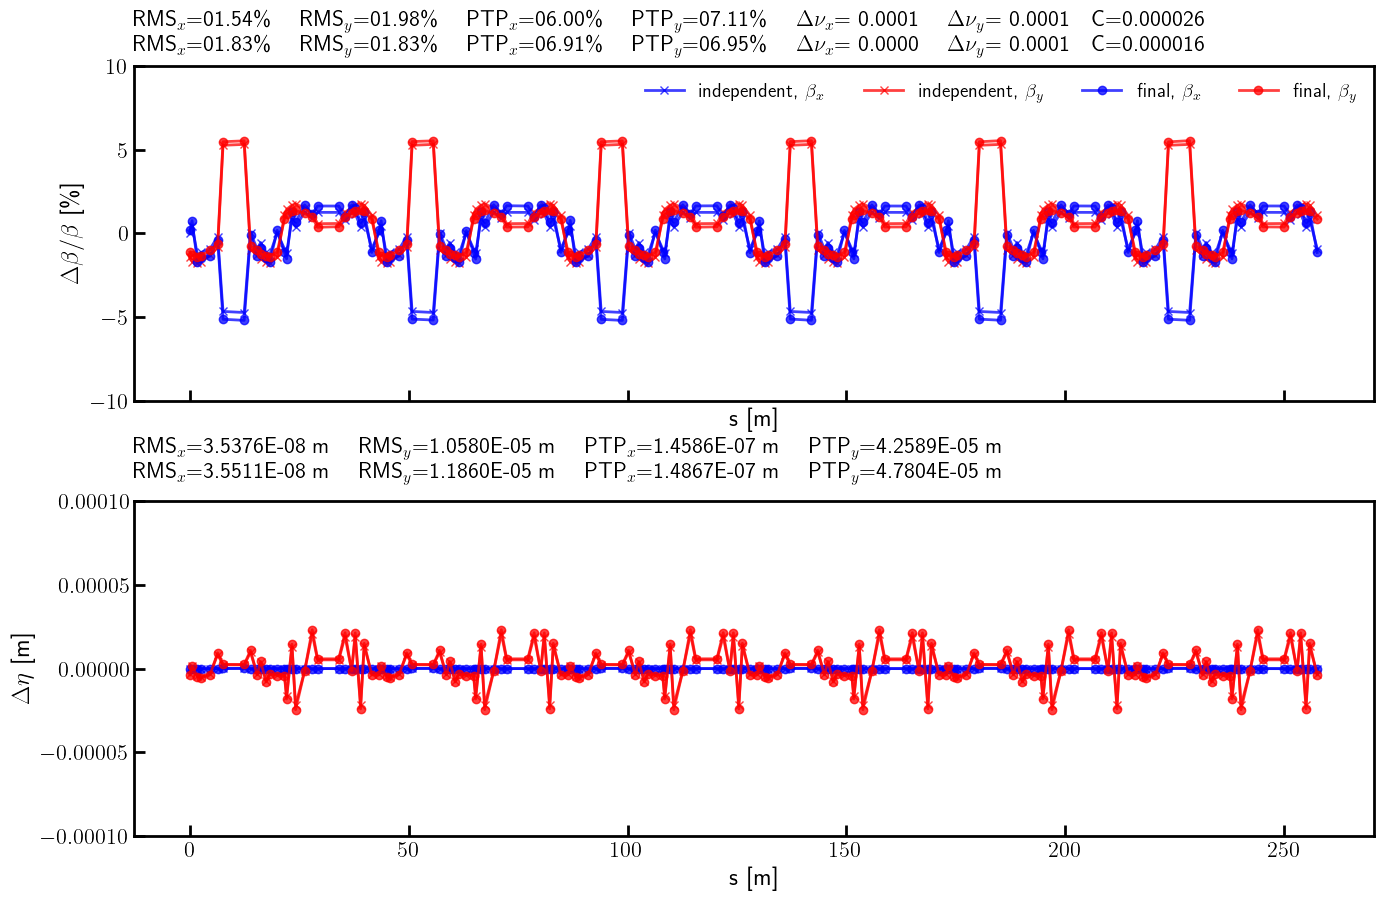

In [127]:
# Beta-beating and dispersion

bx_res_bb = 100.0*(bx - bx_result)/ bx
by_res_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_res = rms(bx_res_bb).item()
ptp_x_res = (bx_res_bb.max() - bx_res_bb.min()).item()
rms_y_res = rms(by_res_bb).item()
ptp_y_res = (by_res_bb.max() - by_res_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_res_np = bx_res_bb.cpu().numpy()
by_res_np = by_res_bb.cpu().numpy()

etax_res = etaqx - etaqx_result
etay_res = etaqy - etaqy_result

rms_etax_res = rms(etax_res).item()
ptp_etax_res = (etax_res.max() - etax_res.min()).item()
rms_etay_res = rms(etay_res).item()
ptp_etay_res = (etay_res.max() - etay_res.min()).item()

etax_res_np = etax_res.cpu().numpy()
etay_res_np = etay_res.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'independent, $\beta_y$')
ax.errorbar(s, bx_res_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'final, $\beta_x$')
ax.errorbar(s, by_res_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'final, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_x_res:05.2f}\% \quad RMS$_y$={rms_y_res:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_res:05.2f}\% \quad PTP$_y$={ptp_y_res:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_final)}{(nux - nux_final).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_final)}{(nuy - nuy_final).abs().item():.4f}'
    rf'\quad C={c_final.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-10, 10)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'independent, $\eta_y$')
ay.errorbar(s, etax_res_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'final, $\eta_x$')
ay.errorbar(s, etay_res_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'final, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_etax_res:.4E} m  \quad RMS$_y$={rms_etay_res:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_res:.4E} m  \quad PTP$_y$={ptp_etay_res:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ay.set_ylim(-1E-4, +1E-4)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [128]:
# Perform correction using all local knobs (occupied sections only) without feed forward

In [129]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Insert correctors

for name, *_ in ring.layout():
    if name.startswith('CH'):
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector])

# Merge drifts

ring.merge()

# Change lattice start start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice

ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Marker': 12}

In [130]:
# Define ID model
# Note, only the flattened triangular part of the A and B matrices is passed

A = torch.tensor([[-0.03484222052711237, 1.0272120741819959E-7, -4.698931299341201E-9, 0.0015923185492594811],
                  [1.0272120579834892E-7, -0.046082787920135176, 0.0017792061173117564, 3.3551298301095784E-8],
                  [-4.6989312853101E-9, 0.0017792061173117072, 0.056853750760983084, -1.5929605363332683E-7],
                  [0.0015923185492594336, 3.3551298348653296E-8, -1.5929605261642905E-7, 0.08311631737263032]], dtype=dtype)

B = torch.tensor([[0.03649353186115209, 0.0015448347221877217, 0.00002719892025520868, -0.0033681183134964482],
                  [0.0015448347221877217, 0.13683886657005795, -0.0033198692682377406, 0.00006140578258682469],
                  [0.00002719892025520868, -0.0033198692682377406, -0.05260095308967722, 0.005019907688182885],
                  [-0.0033681183134964482, 0.00006140578258682469, 0.005019907688182885, -0.2531573249456863]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [131]:
# Insert IDs into the existing lattice

# List of ID markers

sections = ['S01', 'S03', 'S05', 'S07', 'S09', 'S11']

names = [f'MLL_{section}' for section in sections]

error = ring.clone()
error.flatten()
for name in names:
    error.insert(ID, name, position=0.0)
error.splice()

# Describe

error.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Matrix': 1,
 'Marker': 6}

In [132]:
# Local knobs

# Normal quadrupole correctors

nkn = []
for section in sections:
    nkn.extend([f'OCT_{section}_02', f'QF_{section}_02', f'QD_{section}_02', f'QD_{section}_03', f'QF_{section}_03', f'OCT_{section}_03'])

# Skew quadrupole correctors

nks = []
for section in sections:
    nks.extend([f'SD_{section}_05', f'SH_{section}_02', f'SH_{section}_03', f'SD_{section}_06'])

In [133]:
# Define knobs to magnets mixing matrices

Sn = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]], dtype=dtype)
Sn = torch.block_diag(*[Sn]*len(sections))

Ss = torch.tensor([[+1.0, 0.0], [0.0, +1.0], [0.0, -1.0], [-1.0, 0.0]], dtype=dtype)
Ss = torch.block_diag(*[Ss]*len(sections))

In [134]:
# Define observables for 'mixed' knobs

def knobs_split(knobs):
    kn, ks = torch.split(knobs, [3*len(sections), 2*len(sections)])
    kn = Sn @ kn
    ks = Ss @ ks
    return kn, ks


def knobs_build(knobs):
    kn, ks = knobs_split(knobs)
    return (nkn, kn), (nks, ks)


def observable_orm(nn, kn, ns, ks):
    orm = ORM(ring, orbit,  [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), limit=1)
    return orm


def observable(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    orm = observable_orm(nn, kn, ns, ks)
    return orm.flatten()


knobs = torch.tensor((3*len(sections) + 2*len(sections))*[0.0], dtype=dtype)
print((target := observable(knobs)).shape)
print((matrix := torch.func.jacfwd(observable)(knobs)).shape)

torch.Size([16128])
torch.Size([16128, 30])


In [135]:
# Define parametric observable vector

def global_observable(knobs):
    kf, kd = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd])
    return tune(error, [kn], ('kn', None, QF + QD, None), matched=True, limit=1)


def knobs_split(knobs):
    kn, ks = torch.split(knobs, [3*len(sections), 2*len(sections)])
    kn = Sn @ kn
    ks = Ss @ ks
    return kn, ks

def knobs_build(knobs):
    kn, ks = knobs_split(knobs)
    return (nkn, kn), (nks, ks)


def observable_orm(nn, kn, ns, ks):
    orm = ORM(error, orbit,  [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), limit=1)
    return orm


def observable(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    orm = observable_orm(nn, kn, ns, ks)
    return orm.flatten()

In [136]:
# Check the residual vector norm

global_knobs = torch.tensor(2*[0.0], dtype=dtype)
knobs = torch.tensor((3*len(sections) + 2*len(sections))*[0.0], dtype=dtype)

print(((global_observable(global_knobs) - global_target)**2).sum())
print(((observable(knobs) - target)**2).sum())

tensor(0.0264, dtype=torch.float64)
tensor(39445.1029, dtype=torch.float64)


In [137]:
# Optimization loop (local)

# Responce matrix (jacobian)

M = matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

knobs = torch.tensor((3*len(sections) + 2*len(sections))*[0.0], dtype=dtype)

# Correction loop

for _ in range(16):
    value = observable(knobs)
    residual = target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    knobs += lr*delta
    print(((value - target)**2).sum())
print()

tensor(39445.1029, dtype=torch.float64)
tensor(4369.7870, dtype=torch.float64)
tensor(1410.3426, dtype=torch.float64)
tensor(441.6585, dtype=torch.float64)
tensor(142.4922, dtype=torch.float64)
tensor(63.4157, dtype=torch.float64)
tensor(47.9830, dtype=torch.float64)
tensor(45.7673, dtype=torch.float64)
tensor(45.5293, dtype=torch.float64)
tensor(45.5168, dtype=torch.float64)
tensor(45.5204, dtype=torch.float64)
tensor(45.5225, dtype=torch.float64)
tensor(45.5232, dtype=torch.float64)
tensor(45.5235, dtype=torch.float64)
tensor(45.5236, dtype=torch.float64)
tensor(45.5236, dtype=torch.float64)



In [138]:
# Apply final corrections

kn, ks = torch.split(knobs, [3*len(sections), 2*len(sections)])

kn = Sn @ kn
ks = Ss @ ks

error.flatten()

for name, knob in zip(nkn, kn):
    error[name].kn = (error[name].kn + knob).item()
    
for name, knob in zip(nks, ks):
    error[name].ks = (error[name].ks + knob).item()
    
error.splice()

In [139]:
# Compute tunes (fractional part)

nux_final, nuy_final = tune(error, [], matched=True, limit=1)

In [140]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [141]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [142]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [143]:
# Compute coupling

c_final = coupling(error, [])

In [144]:
# Tune shifts

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

print((nux - nux_final).abs())
print((nuy - nuy_final).abs())
print()

tensor(0.0001, dtype=torch.float64)
tensor(9.4279e-05, dtype=torch.float64)

tensor(0.0025, dtype=torch.float64)
tensor(0.0028, dtype=torch.float64)



In [145]:
# Coupling (minimal tune distance)

print(c)
print(c_result)
print(c_final)

tensor(0., dtype=torch.float64)
tensor(2.5678e-05, dtype=torch.float64)
tensor(1.6967e-05, dtype=torch.float64)


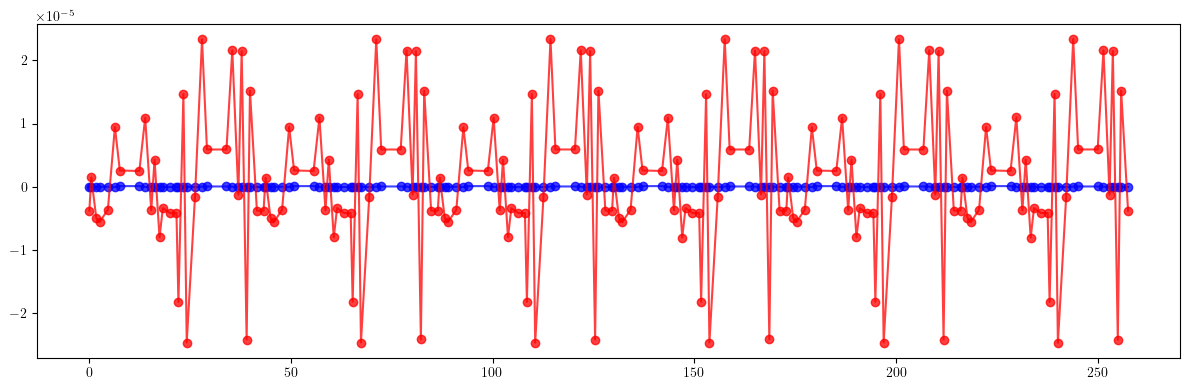

In [146]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

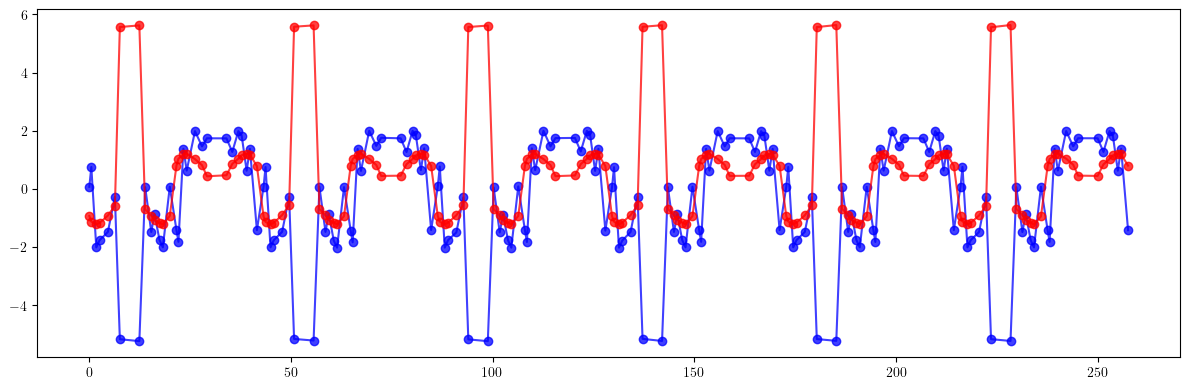

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(1.9602, dtype=torch.float64)
tensor(1.7754, dtype=torch.float64)



In [147]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

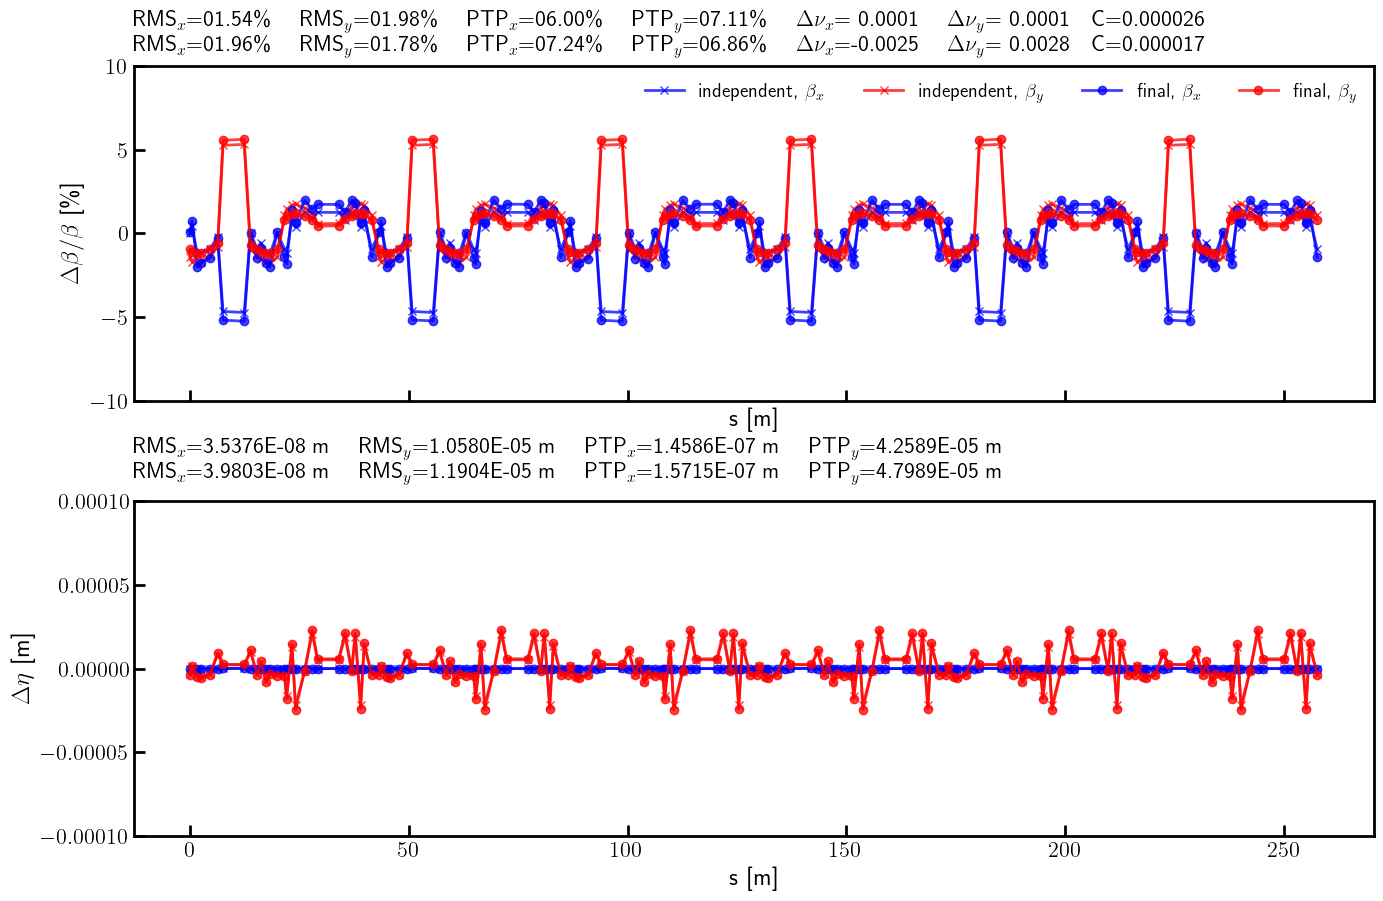

In [148]:
# Beta-beating and dispersion

bx_res_bb = 100.0*(bx - bx_result)/ bx
by_res_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_res = rms(bx_res_bb).item()
ptp_x_res = (bx_res_bb.max() - bx_res_bb.min()).item()
rms_y_res = rms(by_res_bb).item()
ptp_y_res = (by_res_bb.max() - by_res_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_res_np = bx_res_bb.cpu().numpy()
by_res_np = by_res_bb.cpu().numpy()

etax_res = etaqx - etaqx_result
etay_res = etaqy - etaqy_result

rms_etax_res = rms(etax_res).item()
ptp_etax_res = (etax_res.max() - etax_res.min()).item()
rms_etay_res = rms(etay_res).item()
ptp_etay_res = (etay_res.max() - etay_res.min()).item()

etax_res_np = etax_res.cpu().numpy()
etay_res_np = etay_res.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'independent, $\beta_y$')
ax.errorbar(s, bx_res_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'final, $\beta_x$')
ax.errorbar(s, by_res_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'final, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_x_res:05.2f}\% \quad RMS$_y$={rms_y_res:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_res:05.2f}\% \quad PTP$_y$={ptp_y_res:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_final)}{(nux - nux_final).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_final)}{(nuy - nuy_final).abs().item():.4f}'
    rf'\quad C={c_final.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-10, 10)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'independent, $\eta_y$')
ay.errorbar(s, etax_res_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'final, $\eta_x$')
ay.errorbar(s, etay_res_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'final, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_etax_res:.4E} m  \quad RMS$_y$={rms_etay_res:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_res:.4E} m  \quad PTP$_y$={ptp_etay_res:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ay.set_ylim(-1E-4, +1E-4)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [149]:
# Optimization loop (global)

# Responce matrix (jacobian)

M = global_matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

global_knobs = torch.tensor(2*[0.0], dtype=dtype)

# Correction loop

for _ in range(4):
    value = global_observable(global_knobs)
    residual = global_target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    global_knobs += lr*delta
    print(((value - global_target)**2).sum())
print()

tensor(1.4254e-05, dtype=torch.float64)
tensor(9.5310e-07, dtype=torch.float64)
tensor(1.1418e-07, dtype=torch.float64)
tensor(2.5198e-08, dtype=torch.float64)



In [150]:
# Apply final corrections

kd, kf = global_knobs

error.flatten()

for name in QF:
    error[name].kn = (error[name].kn + kd).item()

for name in QD:
    error[name].kn = (error[name].kn + kf).item()
    
error.splice()

In [151]:
# Compute tunes (fractional part)

nux_final, nuy_final = tune(error, [], matched=True, limit=1)

In [152]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [153]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [154]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [155]:
# Compute coupling

c_final = coupling(error, [])

In [156]:
# Tune shifts

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

print((nux - nux_final).abs())
print((nuy - nuy_final).abs())
print()

tensor(0.0001, dtype=torch.float64)
tensor(9.4279e-05, dtype=torch.float64)

tensor(5.6105e-05, dtype=torch.float64)
tensor(5.7786e-05, dtype=torch.float64)



In [157]:
# Coupling (minimal tune distance)

print(c)
print(c_result)
print(c_final)

tensor(0., dtype=torch.float64)
tensor(2.5678e-05, dtype=torch.float64)
tensor(1.6036e-05, dtype=torch.float64)


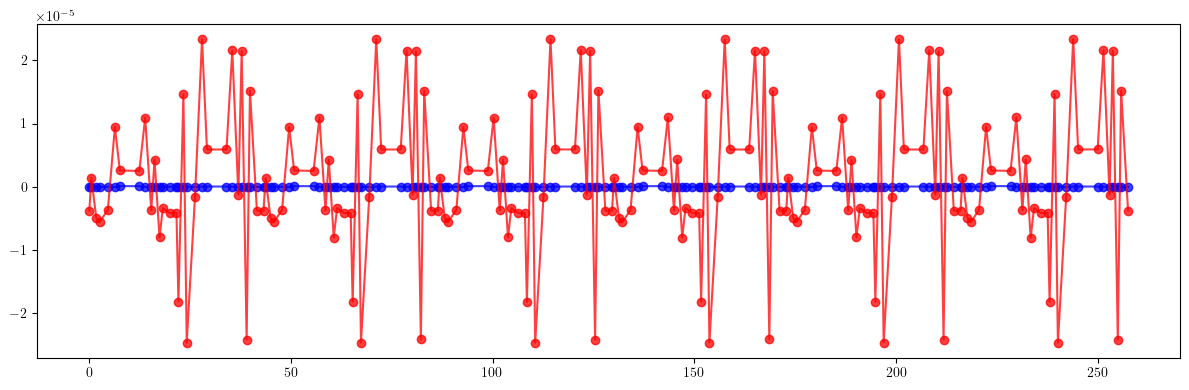

In [158]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

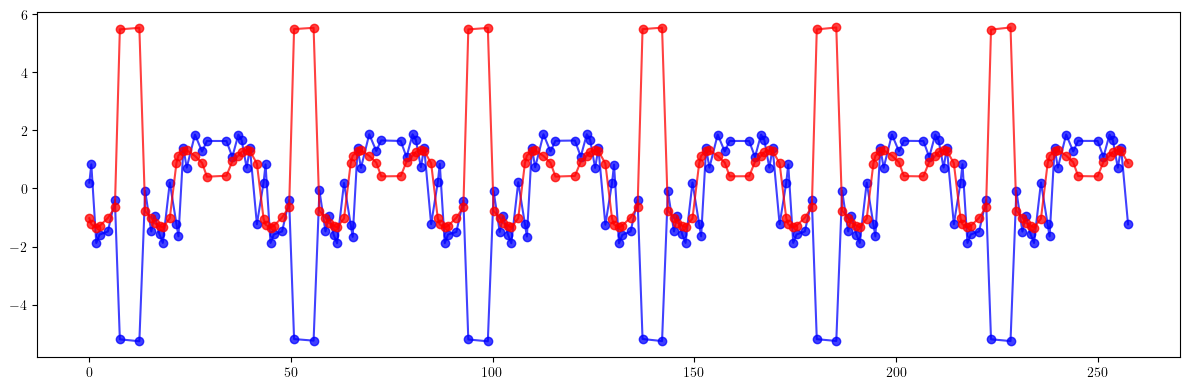

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(1.9025, dtype=torch.float64)
tensor(1.8051, dtype=torch.float64)



In [159]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

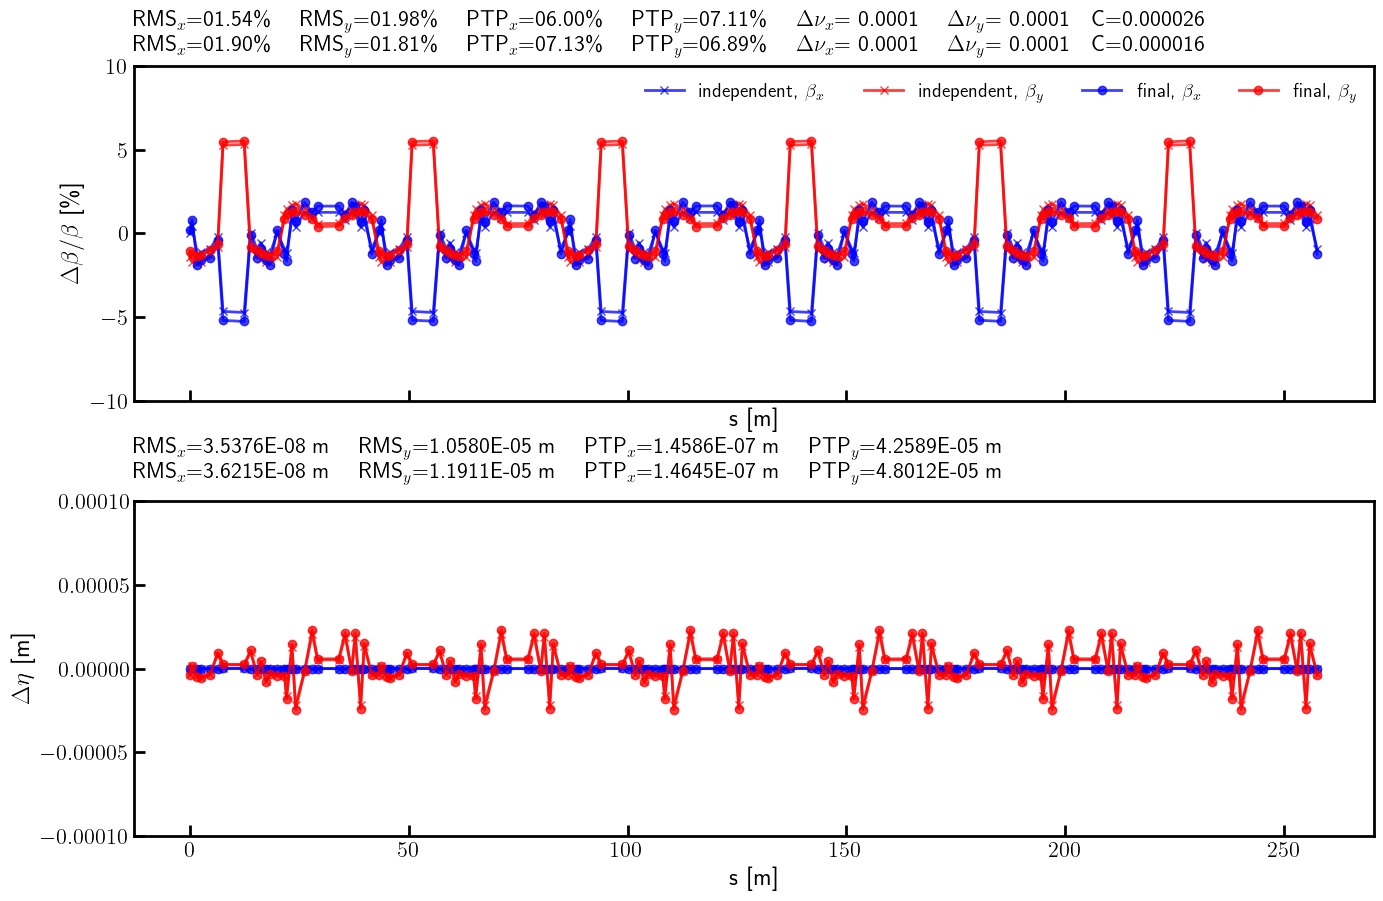

In [160]:
# Beta-beating and dispersion

bx_res_bb = 100.0*(bx - bx_result)/ bx
by_res_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_res = rms(bx_res_bb).item()
ptp_x_res = (bx_res_bb.max() - bx_res_bb.min()).item()
rms_y_res = rms(by_res_bb).item()
ptp_y_res = (by_res_bb.max() - by_res_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_res_np = bx_res_bb.cpu().numpy()
by_res_np = by_res_bb.cpu().numpy()

etax_res = etaqx - etaqx_result
etay_res = etaqy - etaqy_result

rms_etax_res = rms(etax_res).item()
ptp_etax_res = (etax_res.max() - etax_res.min()).item()
rms_etay_res = rms(etay_res).item()
ptp_etay_res = (etay_res.max() - etay_res.min()).item()

etax_res_np = etax_res.cpu().numpy()
etay_res_np = etay_res.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'independent, $\beta_y$')
ax.errorbar(s, bx_res_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'final, $\beta_x$')
ax.errorbar(s, by_res_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'final, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_x_res:05.2f}\% \quad RMS$_y$={rms_y_res:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_res:05.2f}\% \quad PTP$_y$={ptp_y_res:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_final)}{(nux - nux_final).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_final)}{(nuy - nuy_final).abs().item():.4f}'
    rf'\quad C={c_final.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-10, 10)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'independent, $\eta_y$')
ay.errorbar(s, etax_res_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'final, $\eta_x$')
ay.errorbar(s, etay_res_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'final, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_etax_res:.4E} m  \quad RMS$_y$={rms_etay_res:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_res:.4E} m  \quad PTP$_y$={ptp_etay_res:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ay.set_ylim(-1E-4, +1E-4)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [161]:
# Perform correction using all local knobs (all sections) without feed forward

In [162]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Insert correctors

for name, *_ in ring.layout():
    if name.startswith('CH'):
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector])

# Merge drifts

ring.merge()

# Change lattice start start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice

ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Marker': 12}

In [163]:
# Define ID model
# Note, only the flattened triangular part of the A and B matrices is passed

A = torch.tensor([[-0.03484222052711237, 1.0272120741819959E-7, -4.698931299341201E-9, 0.0015923185492594811],
                  [1.0272120579834892E-7, -0.046082787920135176, 0.0017792061173117564, 3.3551298301095784E-8],
                  [-4.6989312853101E-9, 0.0017792061173117072, 0.056853750760983084, -1.5929605363332683E-7],
                  [0.0015923185492594336, 3.3551298348653296E-8, -1.5929605261642905E-7, 0.08311631737263032]], dtype=dtype)

B = torch.tensor([[0.03649353186115209, 0.0015448347221877217, 0.00002719892025520868, -0.0033681183134964482],
                  [0.0015448347221877217, 0.13683886657005795, -0.0033198692682377406, 0.00006140578258682469],
                  [0.00002719892025520868, -0.0033198692682377406, -0.05260095308967722, 0.005019907688182885],
                  [-0.0033681183134964482, 0.00006140578258682469, 0.005019907688182885, -0.2531573249456863]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [164]:
# Insert IDs into the existing lattice

# List of ID markers

sections = ['S01', 'S03', 'S05', 'S07', 'S09', 'S11']

names = [f'MLL_{section}' for section in sections]

error = ring.clone()
error.flatten()
for name in names:
    error.insert(ID, name, position=0.0)
error.splice()

# Describe

error.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 24,
 'Matrix': 1,
 'Marker': 6}

In [165]:
# Local knobs

# Normal quadrupole correctors

sections = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12']

nkn = []
for section in sections:
    nkn.extend([f'OCT_{section}_02', f'QF_{section}_02', f'QD_{section}_02', f'QD_{section}_03', f'QF_{section}_03', f'OCT_{section}_03'])

# Skew quadrupole correctors

nks = []
for section in sections:
    nks.extend([f'SD_{section}_05', f'SH_{section}_02', f'SH_{section}_03', f'SD_{section}_06'])

In [166]:
# Define knobs to magnets mixing matrices

Sn = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]], dtype=dtype)
Sn = torch.block_diag(*[Sn]*len(sections))

Ss = torch.tensor([[+1.0, 0.0], [0.0, +1.0], [0.0, -1.0], [-1.0, 0.0]], dtype=dtype)
Ss = torch.block_diag(*[Ss]*len(sections))

In [167]:
# Define observables for 'mixed' knobs

def knobs_split(knobs):
    kn, ks = torch.split(knobs, [3*len(sections), 2*len(sections)])
    kn = Sn @ kn
    ks = Ss @ ks
    return kn, ks


def knobs_build(knobs):
    kn, ks = knobs_split(knobs)
    return (nkn, kn), (nks, ks)


def observable_orm(nn, kn, ns, ks):
    orm = ORM(ring, orbit,  [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), limit=1)
    return orm


def observable(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    orm = observable_orm(nn, kn, ns, ks)
    return orm.flatten()


knobs = torch.tensor((3*len(sections) + 2*len(sections))*[0.0], dtype=dtype)
print((target := observable(knobs)).shape)
print((matrix := torch.func.jacfwd(observable)(knobs)).shape)

torch.Size([16128])
torch.Size([16128, 60])


In [168]:
# Define parametric observable vector

def global_observable(knobs):
    kf, kd = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd])
    return tune(error, [kn], ('kn', None, QF + QD, None), matched=True, limit=1)


def knobs_split(knobs):
    kn, ks = torch.split(knobs, [3*len(sections), 2*len(sections)])
    kn = Sn @ kn
    ks = Ss @ ks
    return kn, ks

def knobs_build(knobs):
    kn, ks = knobs_split(knobs)
    return (nkn, kn), (nks, ks)


def observable_orm(nn, kn, ns, ks):
    orm = ORM(error, orbit,  [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), limit=1)
    return orm


def observable(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    orm = observable_orm(nn, kn, ns, ks)
    return orm.flatten()

In [169]:
# Check the residual vector norm

global_knobs = torch.tensor(2*[0.0], dtype=dtype)
knobs = torch.tensor((3*len(sections) + 2*len(sections))*[0.0], dtype=dtype)

print(((global_observable(global_knobs) - global_target)**2).sum())
print(((observable(knobs) - target)**2).sum())

tensor(0.0264, dtype=torch.float64)
tensor(39445.1029, dtype=torch.float64)


In [170]:
# Optimization loop (local)

# Responce matrix (jacobian)

M = matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# ORM matrix block weights

nx, ny = 168, 168
mx, my = 24, 24

wxx, wxy, wyx, wyy = 16.0, 1.0, 1.0, 16.0

W = torch.empty((nx + ny, mx + my), dtype=dtype)
W[:nx, :mx] = wxx
W[:nx, mx:] = wxy
W[nx:, :mx] = wyx
W[nx:, mx:] = wyy

weights = W.reshape(-1)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

knobs = torch.tensor((3*len(sections) + 2*len(sections))*[0.0], dtype=dtype)

# Correction loop

for _ in range(16):
    value = observable(knobs)
    residual = target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    knobs += lr*delta
    print(((value - target)**2).sum())
print()

tensor(39445.1029, dtype=torch.float64)
tensor(4257.8708, dtype=torch.float64)
tensor(1169.5550, dtype=torch.float64)
tensor(307.0103, dtype=torch.float64)
tensor(92.6265, dtype=torch.float64)
tensor(42.9823, dtype=torch.float64)
tensor(33.3607, dtype=torch.float64)
tensor(31.9227, dtype=torch.float64)
tensor(31.7659, dtype=torch.float64)
tensor(31.7586, dtype=torch.float64)
tensor(31.7612, dtype=torch.float64)
tensor(31.7624, dtype=torch.float64)
tensor(31.7628, dtype=torch.float64)
tensor(31.7630, dtype=torch.float64)
tensor(31.7630, dtype=torch.float64)
tensor(31.7630, dtype=torch.float64)



In [171]:
# Apply final corrections

kn, ks = torch.split(knobs, [3*len(sections), 2*len(sections)])

kn = Sn @ kn
ks = Ss @ ks

error.flatten()

for name, knob in zip(nkn, kn):
    error[name].kn = (error[name].kn + knob).item()
    
for name, knob in zip(nks, ks):
    error[name].ks = (error[name].ks + knob).item()
    
error.splice()

In [172]:
# Compute tunes (fractional part)

nux_final, nuy_final = tune(error, [], matched=True, limit=1)

In [173]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [174]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [175]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [176]:
# Compute coupling

c_final = coupling(error, [])

In [177]:
# Tune shifts

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

print((nux - nux_final).abs())
print((nuy - nuy_final).abs())
print()

tensor(0.0001, dtype=torch.float64)
tensor(9.4279e-05, dtype=torch.float64)

tensor(0.0029, dtype=torch.float64)
tensor(0.0029, dtype=torch.float64)



In [178]:
# Coupling (minimal tune distance)

print(c)
print(c_result)
print(c_final)

tensor(0., dtype=torch.float64)
tensor(2.5678e-05, dtype=torch.float64)
tensor(7.3972e-06, dtype=torch.float64)


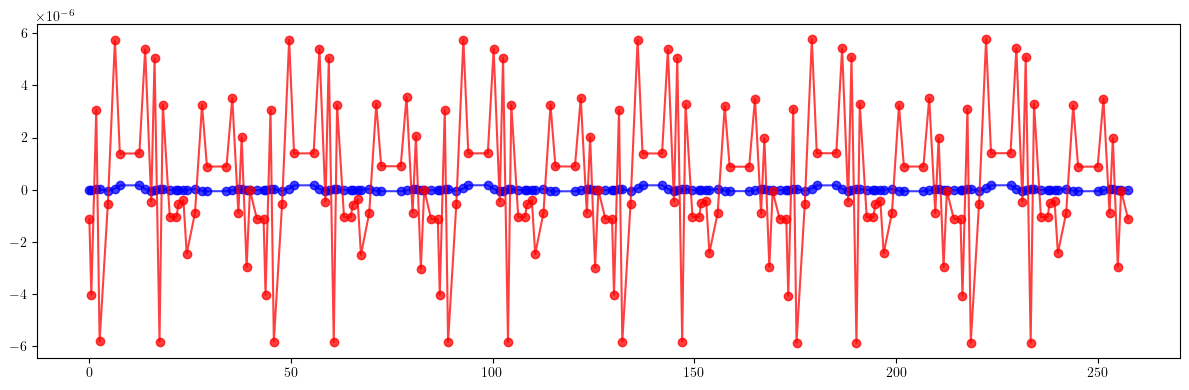

In [179]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

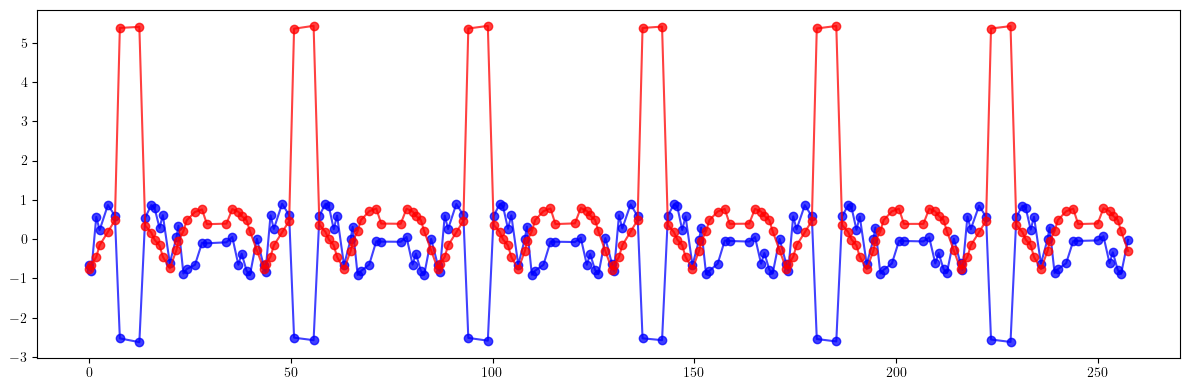

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(0.8904, dtype=torch.float64)
tensor(1.5154, dtype=torch.float64)



In [180]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

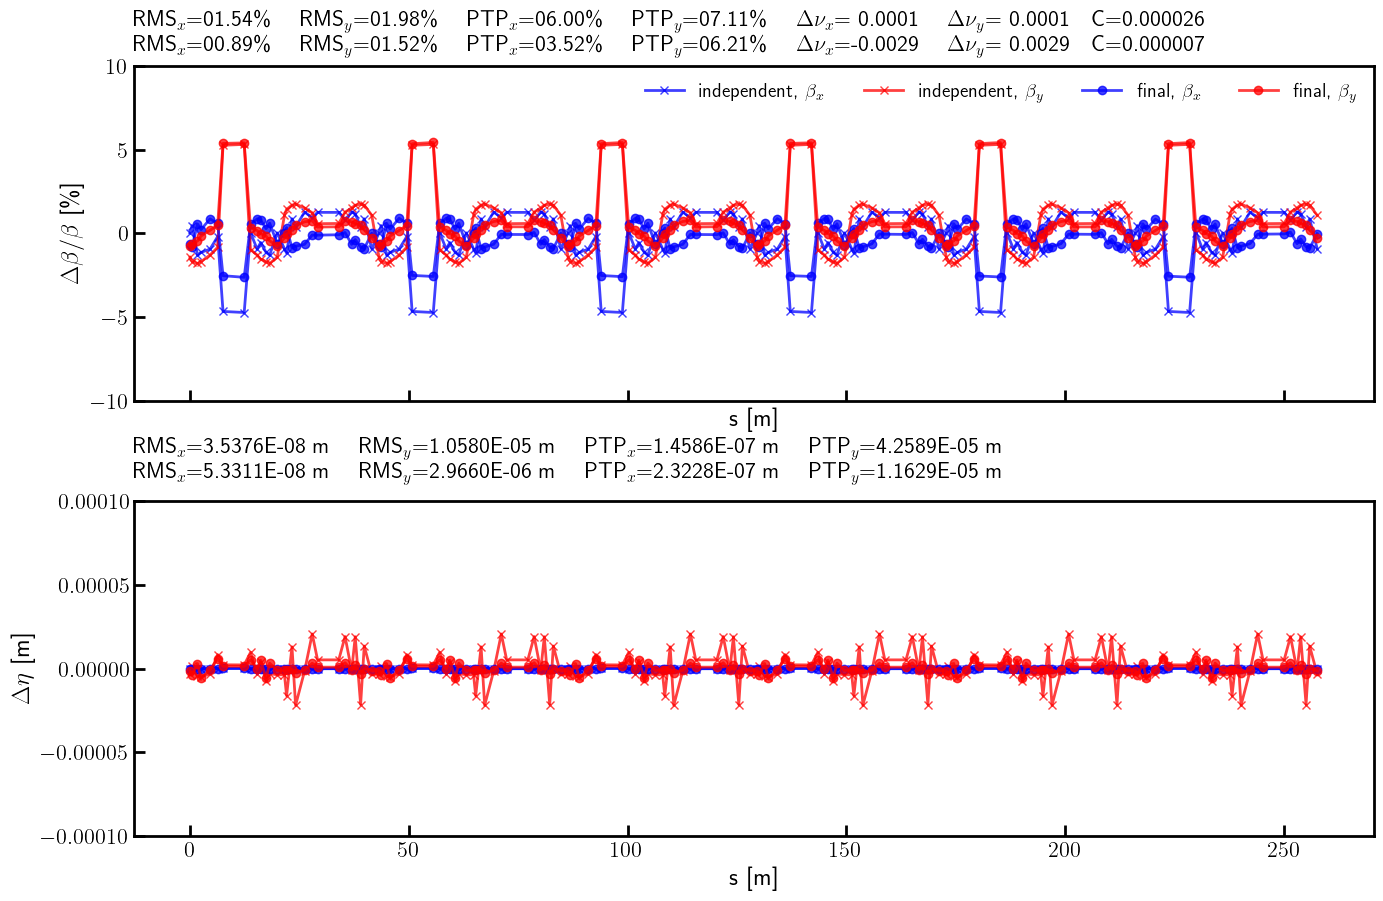

In [181]:
# Beta-beating and dispersion

bx_res_bb = 100.0*(bx - bx_result)/ bx
by_res_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_res = rms(bx_res_bb).item()
ptp_x_res = (bx_res_bb.max() - bx_res_bb.min()).item()
rms_y_res = rms(by_res_bb).item()
ptp_y_res = (by_res_bb.max() - by_res_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_res_np = bx_res_bb.cpu().numpy()
by_res_np = by_res_bb.cpu().numpy()

etax_res = etaqx - etaqx_result
etay_res = etaqy - etaqy_result

rms_etax_res = rms(etax_res).item()
ptp_etax_res = (etax_res.max() - etax_res.min()).item()
rms_etay_res = rms(etay_res).item()
ptp_etay_res = (etay_res.max() - etay_res.min()).item()

etax_res_np = etax_res.cpu().numpy()
etay_res_np = etay_res.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'independent, $\beta_y$')
ax.errorbar(s, bx_res_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'final, $\beta_x$')
ax.errorbar(s, by_res_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'final, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_x_res:05.2f}\% \quad RMS$_y$={rms_y_res:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_res:05.2f}\% \quad PTP$_y$={ptp_y_res:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_final)}{(nux - nux_final).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_final)}{(nuy - nuy_final).abs().item():.4f}'
    rf'\quad C={c_final.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-10, 10)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'independent, $\eta_y$')
ay.errorbar(s, etax_res_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'final, $\eta_x$')
ay.errorbar(s, etay_res_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'final, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_etax_res:.4E} m  \quad RMS$_y$={rms_etay_res:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_res:.4E} m  \quad PTP$_y$={ptp_etay_res:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ay.set_ylim(-1E-4, +1E-4)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [182]:
# Optimization loop (global)

# Responce matrix (jacobian)

M = global_matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

global_knobs = torch.tensor(2*[0.0], dtype=dtype)

# Correction loop

for _ in range(4):
    value = global_observable(global_knobs)
    residual = global_target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    global_knobs += lr*delta
    print(((value - global_target)**2).sum())
print()

tensor(1.6986e-05, dtype=torch.float64)
tensor(1.0979e-06, dtype=torch.float64)
tensor(9.5547e-08, dtype=torch.float64)
tensor(1.3372e-08, dtype=torch.float64)



In [183]:
# Apply final corrections

kd, kf = global_knobs

error.flatten()

for name in QF:
    error[name].kn = (error[name].kn + kd).item()

for name in QD:
    error[name].kn = (error[name].kn + kf).item()
    
error.splice()

In [184]:
# Compute tunes (fractional part)

nux_final, nuy_final = tune(error, [], matched=True, limit=1)

In [185]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [186]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [187]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [188]:
# Compute coupling

c_final = coupling(error, [])

In [189]:
# Tune shifts

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

print((nux - nux_final).abs())
print((nuy - nuy_final).abs())
print()

tensor(0.0001, dtype=torch.float64)
tensor(9.4279e-05, dtype=torch.float64)

tensor(2.6971e-05, dtype=torch.float64)
tensor(4.1914e-05, dtype=torch.float64)



In [190]:
# Coupling (minimal tune distance)

print(c)
print(c_result)
print(c_final)

tensor(0., dtype=torch.float64)
tensor(2.5678e-05, dtype=torch.float64)
tensor(7.2546e-06, dtype=torch.float64)


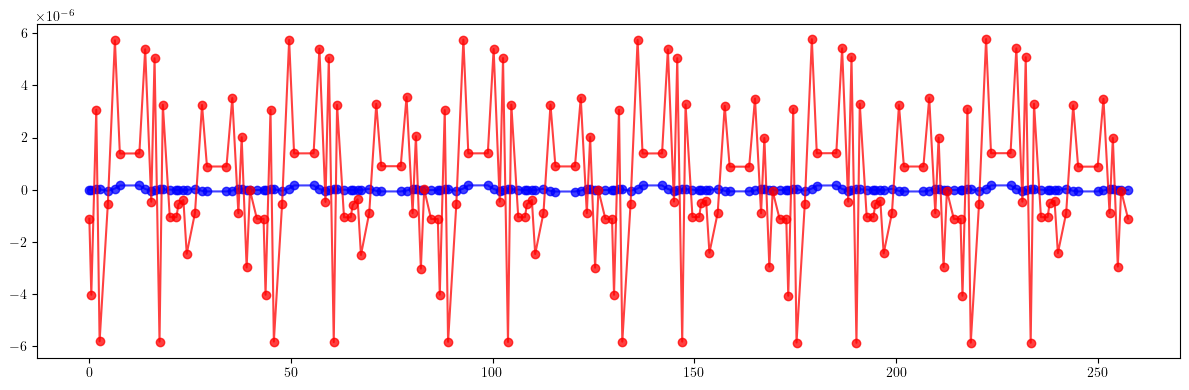

In [191]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

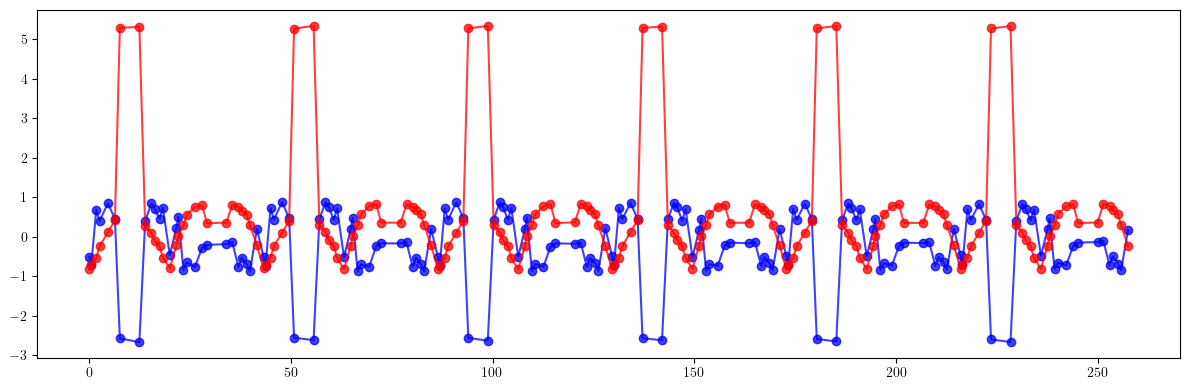

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(0.8978, dtype=torch.float64)
tensor(1.5043, dtype=torch.float64)



In [192]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

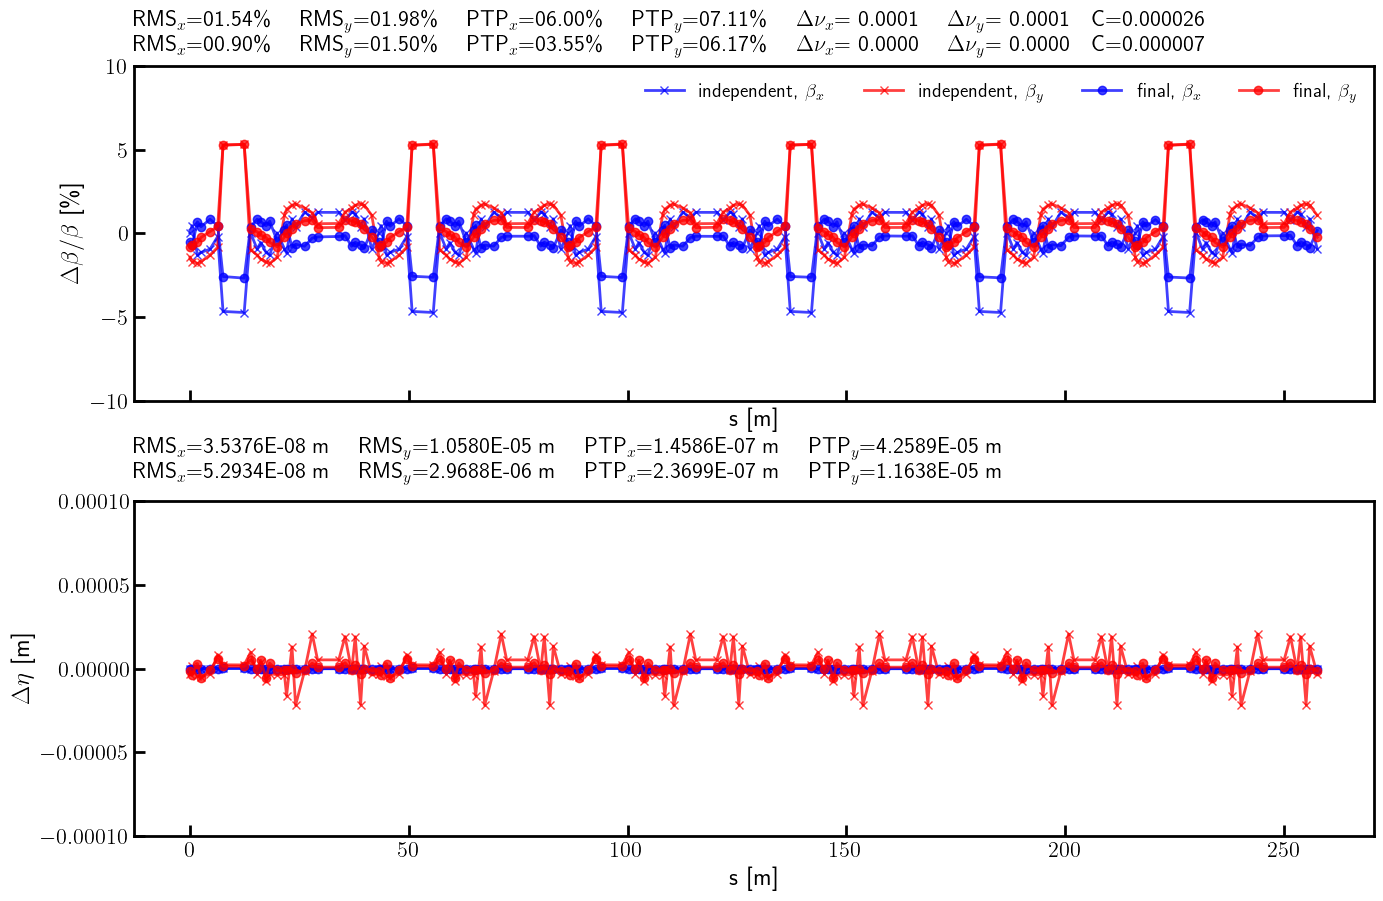

In [193]:
# Beta-beating and dispersion

bx_res_bb = 100.0*(bx - bx_result)/ bx
by_res_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_res = rms(bx_res_bb).item()
ptp_x_res = (bx_res_bb.max() - bx_res_bb.min()).item()
rms_y_res = rms(by_res_bb).item()
ptp_y_res = (by_res_bb.max() - by_res_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_res_np = bx_res_bb.cpu().numpy()
by_res_np = by_res_bb.cpu().numpy()

etax_res = etaqx - etaqx_result
etay_res = etaqy - etaqy_result

rms_etax_res = rms(etax_res).item()
ptp_etax_res = (etax_res.max() - etax_res.min()).item()
rms_etay_res = rms(etay_res).item()
ptp_etay_res = (etay_res.max() - etay_res.min()).item()

etax_res_np = etax_res.cpu().numpy()
etay_res_np = etay_res.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'independent, $\beta_y$')
ax.errorbar(s, bx_res_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'final, $\beta_x$')
ax.errorbar(s, by_res_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'final, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_x_res:05.2f}\% \quad RMS$_y$={rms_y_res:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_res:05.2f}\% \quad PTP$_y$={ptp_y_res:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_final)}{(nux - nux_final).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_final)}{(nuy - nuy_final).abs().item():.4f}'
    rf'\quad C={c_final.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-10, 10)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'independent, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'independent, $\eta_y$')
ay.errorbar(s, etax_res_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'final, $\eta_x$')
ay.errorbar(s, etay_res_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'final, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_etax_res:.4E} m  \quad RMS$_y$={rms_etay_res:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_res:.4E} m  \quad PTP$_y$={ptp_etay_res:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ay.set_ylim(-1E-4, +1E-4)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)
plt.show()